In [209]:
import numpy as np
import pandas as pd
import os
import sys
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

path = r"C:\Users\user\Victor\NoEstacionario\Python"
os.chdir(path)
os.getcwd()

'C:\\Users\\user\\Victor\\NoEstacionario\\Python'

In [210]:
data = pd.read_table("Datos\\Hs_SS_PCs_Cantabria.txt")

In [211]:
# Columns for the Hs dataframe
cols_first = ['yyyy', 'mm', 'dd', 'Hs'] + [col for col in data.columns if col.startswith('PC') and not col.endswith('_SS')]

# Columns for the Surge dataframe
cols_second = ['yyyy', 'mm', 'dd', 'Surge'] + [col for col in data.columns if col.endswith('_SS')]

# Create the two DataFrames
df_hs = data[cols_first]
df_surge = data[cols_second]

In [212]:
# Define the days in a month dictionary
days_in_month = {1: 31, 2: 28.25, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

# Correct the time assignment for df_hs
df_hs = df_hs.copy()  # Ensure it's a copy, avoiding modifying the original DataFrame slice
df_hs['time'] = (
    df_hs['yyyy'] - np.min(df_hs['yyyy'])
    + (df_hs['mm'] - 1) / 12
    + df_hs['dd'] / df_hs['mm'].map(days_in_month) / 12
)

# Correct the time assignment for df_surge
df_surge = df_surge.copy()  # Ensure it's a copy, avoiding modifying the original DataFrame slice
df_surge['time'] = (
    df_surge['yyyy'] - np.min(df_surge['yyyy'])
    + (df_surge['mm'] - 1) / 12
    + df_surge['dd'] / df_surge['mm'].map(days_in_month) / 12
)

In [213]:
# Monthly maxima
# hsmax_data = df_hs.groupby(["yyyy","mm"], as_index=False)["Hs"].max()
# max_idx = df_hs.groupby(["yyyy", "mm"])["Hs"].idxmax().values
# n_return_period = 365.25/12

# Yearly maxima
hsmax_data = df_hs.groupby(["yyyy"], as_index=False)["Hs"].max()
max_idx = df_hs.groupby(["yyyy"])["Hs"].idxmax().values
n_return_period = 365.25

In [214]:
hsmax_data_sorted = np.sort(hsmax_data['Hs'])
sorted_max_idx = np.argsort(hsmax_data['Hs'])

In [215]:
Hsdata = df_hs.drop(columns=["yyyy", "mm", "dd"])
Surgedata = df_surge.drop(columns=["yyyy", "mm", "dd"])

In [216]:
# Hs point-in-time data
hspt = Hsdata.to_numpy()[:,0]
hspt_sort = np.sort(hspt)
# Hs monthly maxima
hsmax = Hsdata.to_numpy()[max_idx,0]
hsmax_sort = np.sort(hsmax)
sorted_max_idx = np.argsort(hsmax)

In [217]:
# Covariables y tiempos
times = Hsdata.to_numpy()[max_idx,-1]
covariates = {col: Hsdata.loc[max_idx,col] for col in Hsdata.columns[1:-1]}

# Scale the covariates
covariates_df = pd.DataFrame(covariates)
scaler = StandardScaler()
scaled_covariates_df = pd.DataFrame(
    scaler.fit_transform(covariates_df), 
    columns=covariates_df.columns
)
scaled_covariates = scaled_covariates_df.to_dict(orient='list')

In [218]:
# Empirical df and Return period for point in time
ecdf_pt_probs = np.arange(1,len(hspt)+1)/(len(hspt)+1)
T_pt = 1/(1-ecdf_pt_probs)/n_return_period

# Empirical df and Return period for monthly maxima
ecdf_ev_probs = np.arange(1,len(hsmax)+1)/(len(hsmax)+1)
T_ev = 1/(1-ecdf_ev_probs)

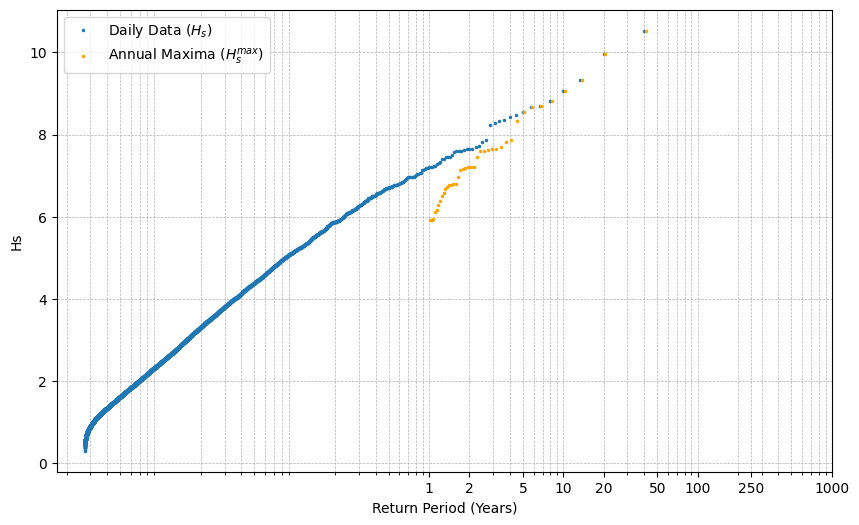

In [219]:
fig = plt.figure(figsize=(10,6))
ax= fig.add_subplot()
ax.semilogx(T_pt, np.sort(hspt), linewidth=0, marker='o',markersize=1.5, label='Daily Data ($H_s$)')
ax.semilogx(T_ev, np.sort(hsmax), color = 'orange',linewidth=0, marker='o',markersize=1.5, label=r'Annual Maxima ($H_s^{max}$)')
ax.semilogx(0,2,color = 'orange',linewidth=0, marker='o',markersize=1.5)
# Configurar escala logarítmica y ticks personalizados
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Mantiene los números sin notación científica

# Etiquetas y grid
ax.set_xlabel('Return Period (Years)')
ax.set_ylabel('Hs')
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Mostrar gráfico
plt.legend()
plt.show()

# Corrección Extremos Anuales en Bloques

- Indices del máximo en la serie diaria: `max_idx`
- Indices ordenados del máximo en la serie maxima: `sorted_max_idx`



#### Paso 1: Ajustar GEV a los máximos anuales

In [220]:
import scipy.stats as stats
import statsmodels.api as sm

shape_gev, loc_gev, scale_gev = stats.genextreme.fit(hsmax) 
print(f"Location: {loc_gev}\nScale: {scale_gev}\nShape: {shape_gev}")

Location: 6.918467262399817
Scale: 0.8294499796678392
Shape: -0.03661367714795377


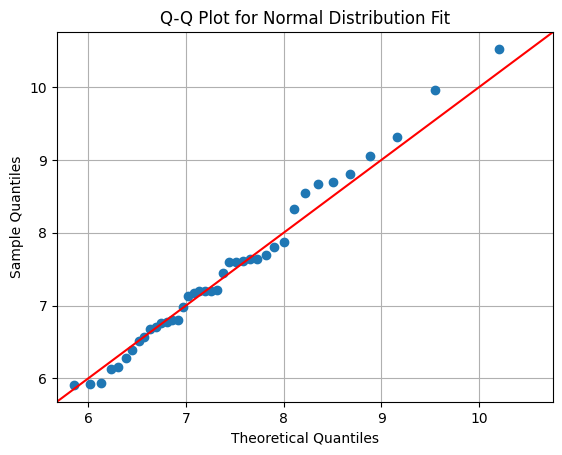

In [221]:
# Q-Q Plot
sm.qqplot(hsmax, stats.genextreme, distargs=(shape_gev,), loc=loc_gev, scale=scale_gev, line="45")
plt.title("Q-Q Plot for Normal Distribution Fit")
plt.grid()
plt.show()

In [222]:
def qgev(prob):
    return stats.genextreme.ppf(prob, shape_gev, loc=loc_gev, scale=scale_gev)

In [223]:
hsmax_corrected = qgev(ecdf_ev_probs)
hsmax_corrected

array([ 5.85595783,  6.01990165,  6.13502693,  6.22855515,  6.30976334,
        6.38304229,  6.45085815,  6.51475588,  6.57578184,  6.63468876,
        6.69204577,  6.74830214,  6.80382675,  6.85893376,  6.91390021,
        6.9689788 ,  7.02440754,  7.08041763,  7.13724024,  7.19511282,
        7.25428546,  7.31502768,  7.37763605,  7.44244343,  7.50983031,
        7.58023939,  7.65419483,  7.73232836,  7.81541559,  7.90442816,
        8.00061059,  8.10559818,  8.22160477,  8.35173784,  8.50056006,
        8.6751728 ,  8.8875369 ,  9.16023657,  9.5444794 , 10.20621164])

#### Paso 2: Obtener los bloques y su transformación

In [224]:
hs_corrected = hspt.copy()
for block_idx, max_value in enumerate(hsmax_sort):
    if block_idx >= len(hsmax)-1:
        hs_corrected[hspt >= hsmax_sort[-1]] = hsmax_corrected[-1]
        break
    else:
        for idx, daily_value in enumerate(hspt):
            if daily_value >= hsmax_sort[block_idx] and daily_value < hsmax_sort[block_idx+1]:
                hs_corrected[idx] = hsmax_corrected[block_idx]+((daily_value-hsmax_sort[block_idx])/(hsmax_sort[block_idx+1]-hsmax_sort[block_idx]))*(hsmax_corrected[block_idx+1]-hsmax_corrected[block_idx])

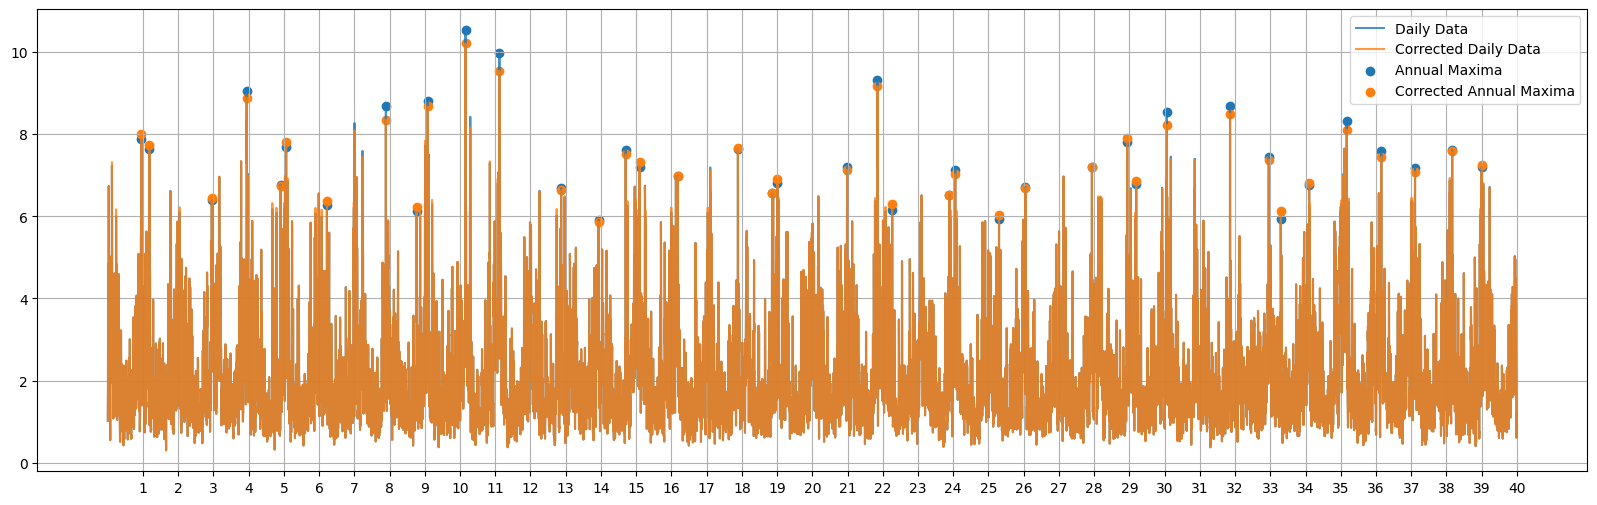

In [225]:
plt.figure(figsize=(20,6))

plt.plot(np.arange(1,len(hspt)+1)/365.25,hspt, label='Daily Data', alpha=0.8)
plt.plot(np.arange(1,len(hspt)+1)/365.25,hs_corrected, label='Corrected Daily Data', alpha=0.8)
plt.scatter(times, hsmax, label='Annual Maxima')
plt.scatter(times, hs_corrected[max_idx], label='Corrected Annual Maxima',)
plt.legend()
plt.xticks(np.arange(1,len(hsmax)+1))
plt.grid()
plt.savefig("Figuras/time_series.png", dpi=200)
plt.show()

In [226]:
x_values_gev = np.linspace(hsmax_sort[0], hsmax_sort[-1], 1000)
return_perd_values_gev = 1/(1-stats.genextreme.cdf(x_values_gev, shape_gev, loc=loc_gev, scale=scale_gev))

ecdf_ev_probs_corrected = stats.genextreme.cdf(qgev(ecdf_ev_probs), shape_gev, loc=loc_gev, scale=scale_gev)
T_ev_corrected = 1/(1-ecdf_ev_probs_corrected)

ecdf_pt_probs_corrected = np.arange(1,len(hs_corrected)+1)/(len(hs_corrected)+1)
T_pt_corrected = 1/(1-ecdf_pt_probs_corrected)/n_return_period

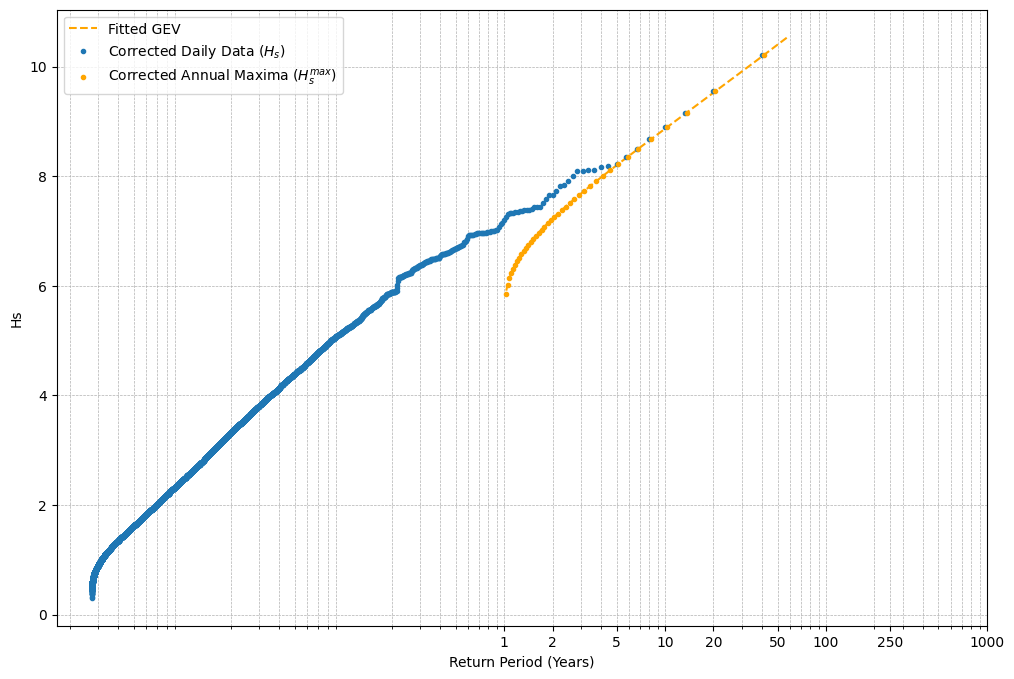

In [227]:
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()
#T_pt, np.sort(hspt)
#ax.semilogx(T_pt, np.sort(hspt), linewidth=1,markersize=1.5)
ax.semilogx(return_perd_values_gev, np.sort(x_values_gev), color = 'orange',linestyle='dashed', label='Fitted GEV')

# Datos corregidos
ax.semilogx(T_pt_corrected, np.sort(hs_corrected), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($H_s$)')
ax.semilogx(T_ev_corrected, qgev(ecdf_ev_probs), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima ($H_s^{max}$)')

# Sin corregir
# ax.semilogx(T_pt, np.sort(hspt), linewidth=0, color='purple', marker='o',markersize=1.5, label='Daily Data ($H_s$)', alpha=0.6)
# ax.semilogx(T_ev, np.sort(hsmax), color = 'green',linewidth=0, marker='o',markersize=1.5, label=r'Annual Maxima ($H_s^{max}$)', alpha=0.6)

ax.set_xlabel('Return Period (Years)')
ax.set_ylabel('Hs')
# Configurar escala logarítmica y ticks personalizados
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Mantiene los números sin notación científica

# Etiquetas y grid
ax.set_xlabel('Return Period (Years)')
ax.set_ylabel('Hs')
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Mostrar gráfico
plt.legend()
plt.savefig("Figuras/corrected_return_periods.png", dpi=200)
plt.show()

#### Con una clase

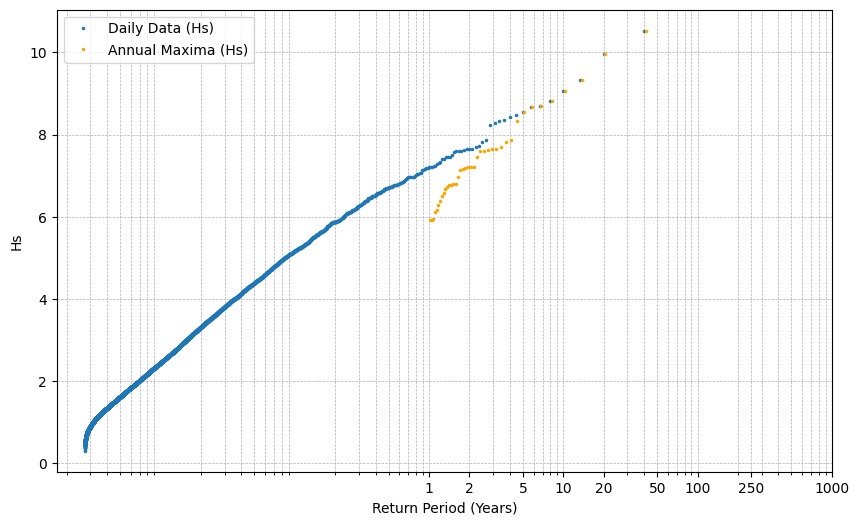

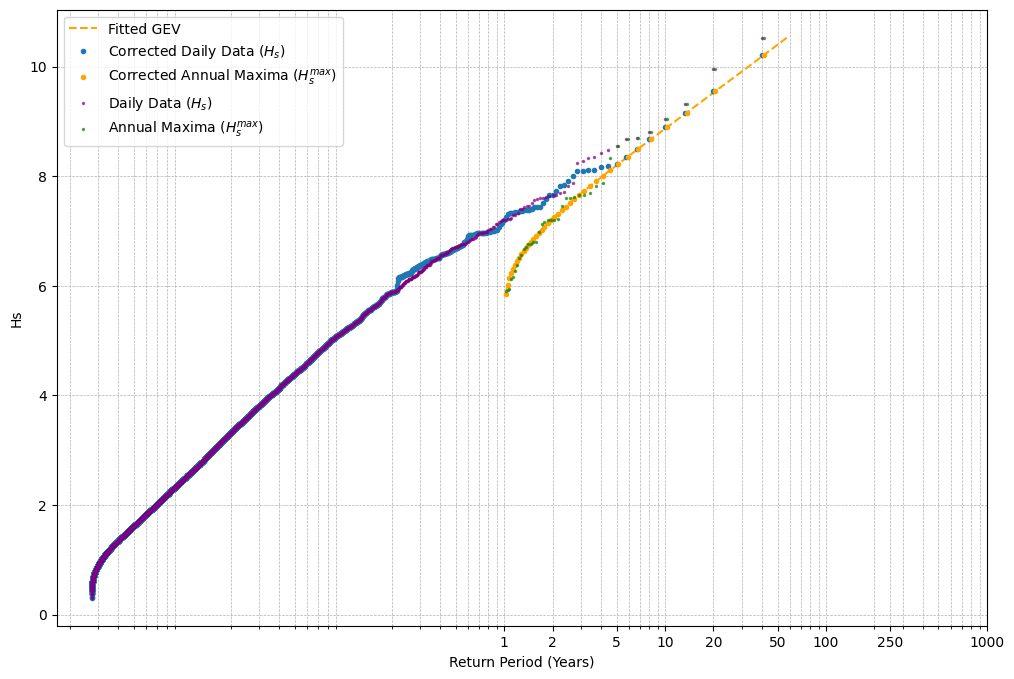

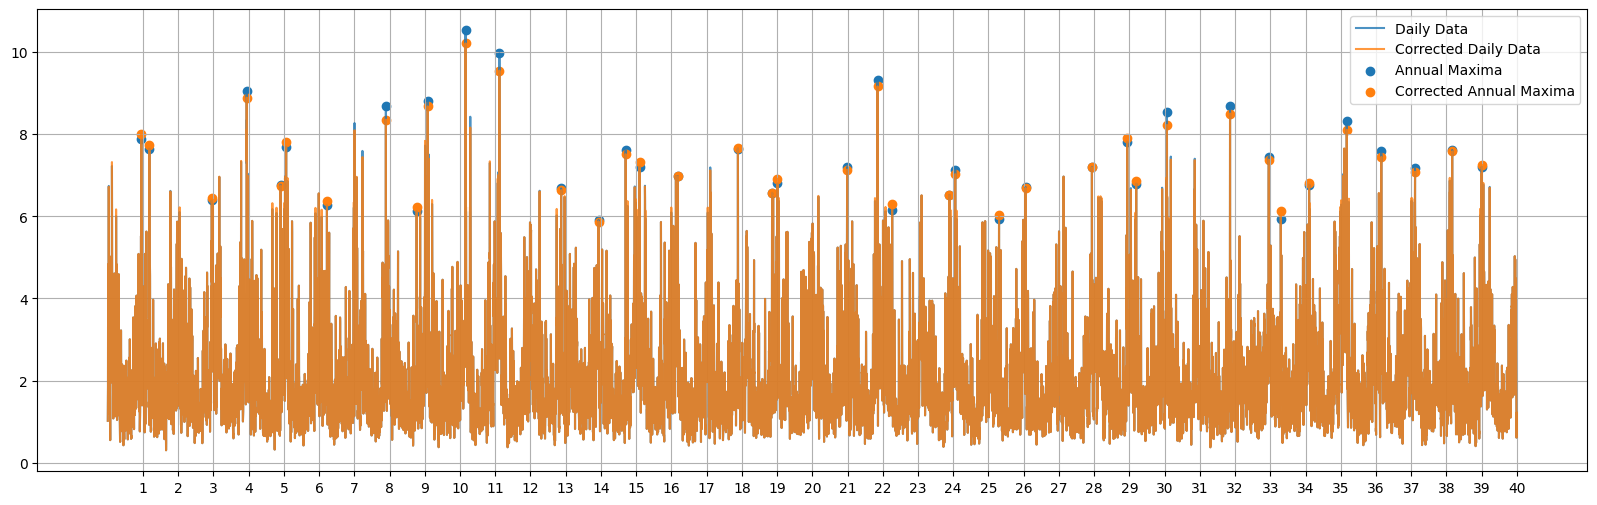

In [228]:
from extremecorrection import ExtremeCorrection

extremecorr = ExtremeCorrection(df_hs)
extremecorr.return_period_plot()
extremecorr.return_period_plot_corrected(without_corr=True)
extremecorr.plot_ts()

# Corrección Extremos Mensuales

In [229]:
# Monthly maxima
hsmax_data_mm = df_hs.groupby(["yyyy","mm"], as_index=False)["Hs"].max()['Hs'].values
max_idx_mm = df_hs.groupby(["yyyy", "mm"])["Hs"].idxmax().values
n_return_period_mm = 365.25/12

In [278]:
# Empirical df and Return period for point in time
ecdf_pt_probs = np.arange(1,len(hspt)+1)/(len(hspt)+1)
T_pt = 1/(1-ecdf_pt_probs)/n_return_period_mm

# Empirical df and Return period for monthly maxima
ecdf_ev_probs_mm = np.arange(1,len(hsmax_data_mm)+1)/(len(hsmax_data_mm)+1)
T_ev_mm = 1/(1-ecdf_ev_probs_mm)

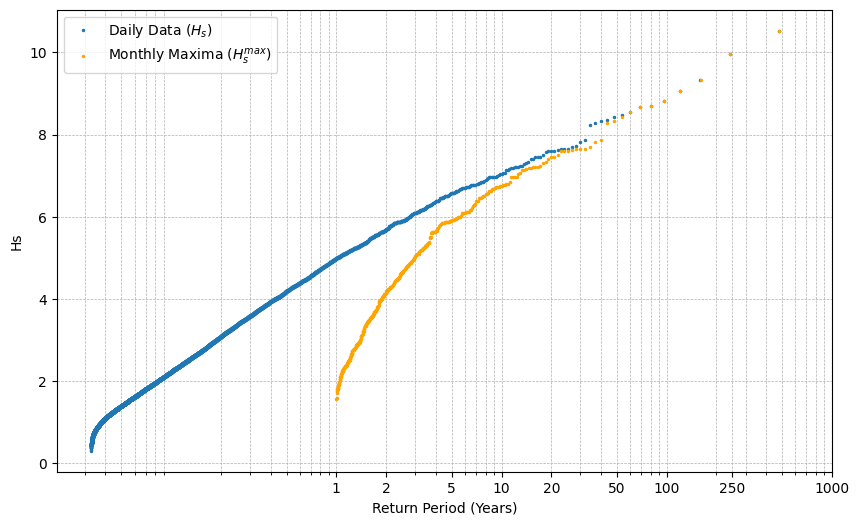

In [279]:
fig = plt.figure(figsize=(10,6))
ax= fig.add_subplot()
ax.semilogx(T_pt, np.sort(hspt), linewidth=0, marker='o',markersize=1.5, label='Daily Data ($H_s$)')
ax.semilogx(T_ev_mm, np.sort(hsmax_data_mm), color = 'orange',linewidth=0, marker='o',markersize=1.5, label=r'Monthly Maxima ($H_s^{max}$)')
ax.semilogx(0,2,color = 'orange',linewidth=0, marker='o',markersize=1.5)
# Configurar escala logarítmica y ticks personalizados
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Mantiene los números sin notación científica

# Etiquetas y grid
ax.set_xlabel('Return Period (Years)')
ax.set_ylabel('Hs')
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Mostrar gráfico
plt.legend()
plt.show()

#### Paso 1: Ajustar una GEV con términos armónicos en el máximo mensual

In [280]:
from Daily_Hs_StormSurge_ScipyJax.non_stationary_model import NonStationaryModel
import jax.numpy as jnp
import time

xt = hsmax_data_mm
t = Hsdata.to_numpy()[max_idx_mm,-1]

# 1. Definición de los datos
xt=jnp.array(xt)
t =jnp.array(t)

# Parámetros iniciales
n_harmonics_loc = 1     # Número de armónicos para ubicación
n_harmonics_scale = 1   # Número de armónicos para escala
n_harmonics_shape = 1   # Número de armónicos para forma
betaT = 0               # Tendencia en localización
betaT2 = 0              # Tendencia en escala
# rhocoeff = 6000  # Coeficiente de penalización Lasso

model_lasso = NonStationaryModel(
    xt=xt,
    t=t,
    covariates_loc=jnp.empty((len(xt),0)),
    covariates_sc=jnp.empty((len(xt),0)),
    covariates_sh=jnp.empty((len(xt),0)),
    n_harmonics_loc=n_harmonics_loc,
    n_harmonics_scale=n_harmonics_scale,
    n_harmonics_shape=n_harmonics_shape,
    betaT=betaT,
    betaT2=betaT2,
    #rhocoeff=rhocoeff,
    regularization_type="lasso",
    example='Monthly Maxima Hs'
)

In [281]:
print("Ajustando modelo con regularización Lasso...")
# Iniciar el temporizador
start_time = time.time()
result_lasso = model_lasso.fit(rhocoeff=0, method='lbfgsb', maxiter=1000, linesearch='zoom')  # linesearch='hager-zhang', 'zoom', 'backtracking'
# Detener el temporizador
end_time = time.time()
# Calcular el tiempo transcurrido
elapsed_time = end_time - start_time
print(f"Tiempo de ejecución L-BFGS-B Grid Search con lasso: {elapsed_time:.2f} segundos")
print("Ajuste completado.\n")

# 9. Obtener y mostrar parámetros ajustados para Lasso
print(f"Valor óptimo de verosimilitud: {result_lasso['loglik']}")
print("\nParámetros ajustados con Lasso:")
model_lasso.summary()

final_parameters = result_lasso['params']

Ajustando modelo con regularización Lasso...
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:1.0  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.5  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.25  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 4 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.125  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 5 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.0625  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 6 Minimum Decrease & Curvature Errors (stop. crit.): inf Stepsize:0.03125  Decrease Error:inf  Curvature Error:inf 
INFO: jaxopt.ZoomLineSearch: Iter: 7 Minimum Decrease & Curvatu

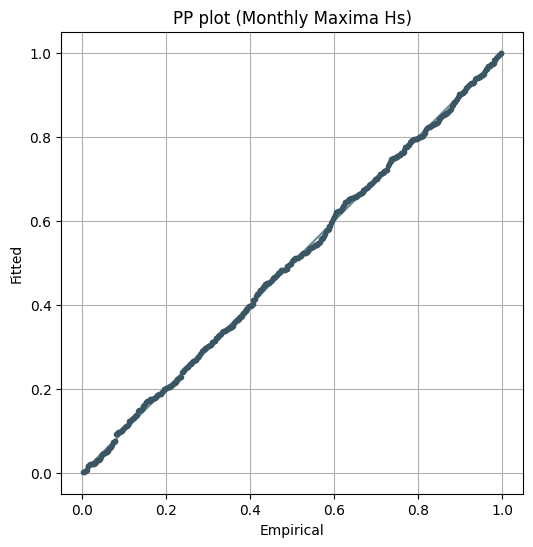

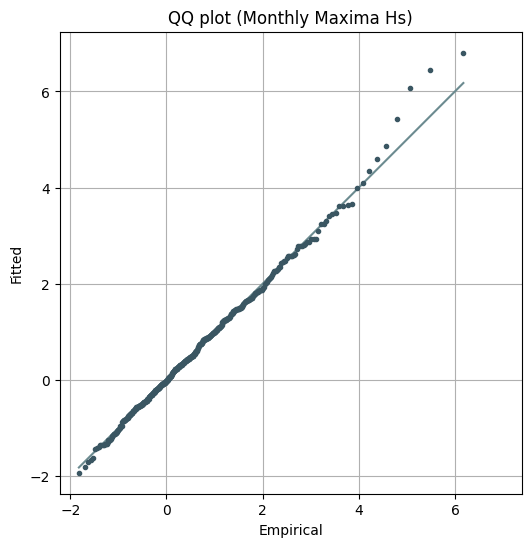

In [282]:
model_lasso.PPplot()
model_lasso.QQplot()

#### Paso 2: Obtener los bloques para la transformación

Aggregated quantiles

In [285]:
def _parametro(alpha0=None,alpha=None,x=None):
    """
    This function computes the location, scale and shape parameters for given parameters. Expressions by (2)-(3) in the paper

    Inputs:
    - alpha0: Value of the intercept
    - alpha: Value of the harmonics terms
    - betaT: tendency for the location parameter, just need to include a number in order to consider it, otherwise leave it empty
    - covariates: Covariates data related to the location parameter, a matrix including the data at time t for each covariate
    - varphi: covariate parameter vector associated with the location parameter, just need to include a list of numbers of length the number of covariates, otherwise leave it empty
    - indicesint: covariate mean values in the integral interval
    - times: times when covariates are known, nearest value (function _search)

    Output:
    - y: values of the parameter
    """

    t = np.array([x])

    harmonic_terms_mu = np.sum(np.array([
        alpha[2*k] * np.cos((k+1) * 2 * np.pi * t) +
        alpha[2*k + 1] * np.sin((k+1) * 2 * np.pi * t)
        for k in range(len(alpha)//2)
    ]), axis=0)
    mu = alpha0 + harmonic_terms_mu
            
    return np.asarray(mu).flatten()

In [286]:
def _fzeroquanint(t,zq,q,beta0,beta,alpha0,alpha,gamma0,gamma):
    """
    Function to solve the quantile
    """
    
    # Evaluate the location parameter at each time t as a function of the actual values of the parameters given by p
    mut1 = _parametro(beta0, beta,t)
    # Evaluate the scale parameter at each time t as a function of the actual values of the parameters given by p
    psit1 = np.exp(_parametro(alpha0, alpha,t))
    # Evaluate the sahpe parameter at each time t as a function of the actual values of the parameters given by p
    epst = _parametro(alpha0=gamma0, alpha=gamma, x=t)

    # The values whose shape parameter is almost cero corresponds to the GUMBEL distribution, locate their positions if they exist
    posG = np.where(np.abs(epst) <= 1e-8)[0]
    # The remaining values correspond to WEIBULL or FRECHET
    pos = np.where(np.abs(epst) > 1e-8)[0]
    # The corresponding GUMBEl values are set to 1 to avoid numerical problems, note that for those cases the GUMBEL expressions are used
    epst[posG] = 1

    kt = np.ones(len(mut1))

    mut = mut1
    psit = psit1
    mut[pos] = mut1[pos] + psit1[pos] * (kt[pos] ** epst[pos] - 1) / epst[pos]
    psit[pos] = psit1[pos] * kt[pos] ** epst[pos]
    # Modify the parameters to include Gumbel
    mut[posG] += psit[posG] * np.log(kt[posG])

    # Evaluate the auxiliary variable
    xn = (zq-mut)/psit
    z = 1+epst*xn
    # Since the z-values must be greater than zero in order to avoid numerical problems their values are set to be greater than 1e-4
    z = np.maximum(1e-4,z)
    zn = z**(-1/epst)

    # GUMBEL case
    zn[posG] = np.exp(-xn[posG])

    return zn

In [287]:
def _fzeroderiquanint(t,zq,q,beta0,beta,alpha0,alpha,gamma0,gamma):
    """
    Function to solve the quantile
    """
    # Evaluate the location parameter at each time t as a function of the actual values of the parameters given by p
    mut1 = _parametro(beta0, beta,t)
    # Evaluate the scale parameter at each time t as a function of the actual values of the parameters given by p
    psit1 = np.exp(_parametro(alpha0, alpha,t))
    # Evaluate the sahpe parameter at each time t as a function of the actual values of the parameters given by p
    epst = _parametro(alpha0=gamma0, alpha=gamma, x=t)

    # The values whose shape parameter is almost cero corresponds to the GUMBEL distribution, locate their positions if they exist
    posG = np.where(np.abs(epst) <= 1e-8)[0]
    # The remaining values correspond to WEIBULL or FRECHET
    pos = np.where(np.abs(epst) > 1e-8)[0]
    # The corresponding GUMBEl values are set to 1 to avoid numerical problems, note that for those cases the GUMBEL expressions are used
    epst[posG] = 1

    kt = np.ones(len(mut1))

    mut = mut1
    psit = psit1
    mut[pos] = mut1[pos] + psit1[pos] * (kt[pos] ** epst[pos] - 1) / epst[pos]
    psit[pos] = psit1[pos] * kt[pos] ** epst[pos]
    # Modify the parameters to include Gumbel
    mut[posG] += psit[posG] * np.log(kt[posG])

    # Evaluate the auxiliary variable
    xn = (zq-mut)/psit
    z = 1+epst*xn
    # Since the z-values must be greater than zero in order to avoid numerical problems their values are set to be greater than 1e-4
    z = np.maximum(1e-4,z)
    zn = -z**(-1-1/epst)/psit
    # GUMBEL case
    zn[posG] = -np.exp(-xn[posG])/psit[posG]

    return zn    

In [288]:
from scipy.integrate import quad, simpson

def _aggquantile(q, t0, t1, coeffs):
    """
    Function to compute the aggregated quantile for certain parameters
    """
    # Obtain coefficients
    beta0 = np.asarray(coeffs['beta0'])
    beta = np.asarray(coeffs['beta'])

    alpha0 = np.asarray(coeffs['alpha0'])
    alpha = np.asarray(coeffs['alpha'])

    gamma0 = np.asarray(coeffs['gamma0'])
    gamma = np.asarray(coeffs['gamma'])

    q = np.array([q])
    t0 = np.array([t0])
    t1 = np.array([t1])
    m = len(q)
    m0 = len(t0)
    m1 = len(t1)
    if m != m0:
        ValueError("Initial quantile aggregated integration time size must be equal than the quantile size")
    if m != m1:
        ValueError("Final quantile aggregated integration time size must be equal than the quantile size")

    # Require quantile
    zqout = np.zeros(m)
    

    media, _ = quad(lambda x: _parametro(beta0,beta,x).item(), 0,1)
    #std, _ = quad(lambda x: np.exp(_parametro(alpha0,alpha,x).item()), 0,1)

    for il in range(m):
        #for jl in range(n)
        zq = media
        err = 1
        iter = 1
        while err > 1e-4 and iter < 1000:
            zqold = zq
            integ, _ = quad(lambda x: _fzeroquanint(x,zqold,q[il],beta0,beta,alpha0,alpha,gamma0,gamma),float(t0[il]),float(t1[il]))
            integ += np.log(q[il])/12#*(float(t1[il])-float(t0[il]))
            dint, _ = quad(lambda x: _fzeroderiquanint(x,zqold,q[il],beta0,beta,alpha0,alpha,gamma0,gamma),float(t0[il]),float(t1[il]))
            zq += -integ/dint
            if np.abs(zqold) > 1e-5:
                err = np.abs((zq-zqold)/zqold)
            else:
                err = np.abs(zq-zqold)
            # print(zq)
            iter += 1
        if iter == 1000:
            zq = np.nan
            Warning("Maximum number of Newton iterations")
        if integ > 1e-2:
            zq = np.nan
            Warning("False zero, check it")
        zqout[il] = zq
        
    return zqout

In [289]:
def loglikelihood(params):
    """
    Define el modelo no estacionario.

    Args:
        params (jnp.array): Parámetros del modelo.

    Returns:
        jnp.array: Log-verosimilitud del modelo.
    """
    # Extraer parámetros
    beta0 = params['beta0']
    beta = params['beta']

    alpha0 = params['alpha0']
    alpha = params['alpha'] 

    gamma0 = params['gamma0']
    gamma = params['gamma'] 

    # Cálculos de mu, sigma, xi
    harmonic_terms_mu = jnp.sum(jnp.array([
        beta[2*k] * jnp.cos((k+1) * 2 * jnp.pi * t) +
        beta[2*k + 1] * jnp.sin((k+1) * 2 * jnp.pi * t)
        for k in range(beta.size)
    ]), axis=0)
    mu = beta0 + harmonic_terms_mu 

    harmonic_terms_sigma = jnp.sum(jnp.array([
        alpha[2*k] * jnp.cos((k+1) * 2 * jnp.pi * t) +
        alpha[2*k + 1] * jnp.sin((k+1) * 2 * jnp.pi * t)
        for k in range(alpha.size)
    ]), axis=0)
    sigma = jnp.maximum(1e-5, jnp.exp(alpha0 + harmonic_terms_sigma))
    #sigma = jnp.exp(alpha0 + harmonic_terms_sigma + betaT2 * self.t + jnp.dot(self.covariates_sc, varphi2))

    harmonic_terms_xi = jnp.sum(jnp.array([
        gamma[2*k] * jnp.cos((k+1) * 2 * jnp.pi * t) +
        gamma[2*k + 1] * jnp.sin((k+1) * 2 * jnp.pi * t)
        for k in range(gamma.size)
    ]), axis=0)
    xi = gamma0 + harmonic_terms_xi 

    xn = (xt - mu) / sigma
    z = 1 + xi * xn
    z = jnp.maximum(z, 1e-8)

    # Gumbel version (xi close to 0)
    loglik_gumbel = jnp.where(
        jnp.abs(xi) < 1e-8,
        jnp.log(sigma) + xn + jnp.exp(-xn),
        0.0  # Para los que no cumplen la condición
    )

    # General version (xi != 0)
    loglik_general = jnp.where(
        jnp.abs(xi) >= 1e-8,
        jnp.log(sigma) +
        (1 + 1 / xi) * jnp.log(z) +
        z ** (-1 / xi),
        0.0  # Para los que no cumplen la condición
    )

    # Combine the results
    loglik = jnp.sum(loglik_gumbel) + jnp.sum(loglik_general)

    return -loglik

In [291]:
from jax.flatten_util import ravel_pytree
import jax

flat_params, unravel_fn = ravel_pytree(final_parameters)

def loglik_fn_for_hessian(flat):
    # Convertimos flat en la estructura original
    original_params = unravel_fn(flat)
    return loglikelihood(original_params)


def hessian_loglik(flat_params):
    """
    Calcula la Hessiana de _loglikelihood en los parámetros 'params'.
    """
    # Calculamos la Hessiana con jax
    H = jax.hessian(loglik_fn_for_hessian)(flat_params)
    return H

In [294]:
hess = hessian_loglik(flat_params)
invI0 = jnp.linalg.inv(-hess)

In [295]:
def _ConfidInterQuanAggregate(q, t0, t1, coeffs):
    """
    Auxiliar function to compute the std for the aggregated quantiles
    """
    # Obtain coefficients
    beta0 = np.asarray(coeffs['beta0'])
    beta = np.asarray(coeffs['beta'])

    alpha0 = np.asarray(coeffs['alpha0'])
    alpha = np.asarray(coeffs['alpha'])

    gamma0 = np.asarray(coeffs['gamma0'])
    gamma = np.asarray(coeffs['gamma'])
    
    # Total length of the data
    n = beta0.size + beta.size + alpha0.size + alpha.size + gamma0.size + gamma.size

    # Initialize the Jacobian
    jacob = np.zeros(n)

    epsi = 1e-4

    # beta0 derivative
    aux = 0
    coeffs_beta0_1 = coeffs.copy()
    coeffs_beta0_2 = coeffs.copy()
    coeffs_beta0_2['beta0'] = beta0*(1+epsi)
    coeffs_beta0_1['beta0'] = beta0*(1-epsi)
    jacob[aux] = (_aggquantile(q,t0,t1,coeffs_beta0_2)[0]-_aggquantile(q,t0,t1,coeffs_beta0_1)[0])/(2*beta0*epsi)

    # beta derivatives
    if beta.size != 0:
        for i in range(beta.size):
            aux += 1
            coeffs_beta1 = coeffs.copy()
            coeffs_beta2 = coeffs.copy()
            coeffs_beta2['beta'] = coeffs_beta2['beta'].at[i].set(beta[i]*(1+epsi))
            coeffs_beta1['beta'] = coeffs_beta1['beta'].at[i].set(beta[i]*(1-epsi))
            jacob[aux] = (_aggquantile(q,t0,t1,coeffs_beta2)[0]-_aggquantile(q,t0,t1,coeffs_beta1)[0])/(2*beta[i]*epsi)

    # alpha0 derivative
    aux += 1
    coeffs_alpha0_1 = coeffs.copy()
    coeffs_alpha0_2 = coeffs.copy()
    coeffs_alpha0_2['alpha0'] = alpha0*(1+epsi)
    coeffs_alpha0_1['alpha0'] = alpha0*(1-epsi)
    jacob[aux] = (_aggquantile(q,t0,t1,coeffs_alpha0_2)[0]-_aggquantile(q,t0,t1,coeffs_alpha0_1)[0])/(2*alpha0*epsi)

    # alpha derivatives
    if alpha.size != 0:
        for i in range(alpha.size):
            aux += 1
            coeffs_alpha1 = coeffs.copy()
            coeffs_alpha2 = coeffs.copy()
            coeffs_alpha2['alpha'] = coeffs_alpha2['alpha'].at[i].set(alpha[i]*(1+epsi))
            coeffs_alpha1['alpha'] = coeffs_alpha1['alpha'].at[i].set(alpha[i]*(1-epsi))
            jacob[aux] = (_aggquantile(q,t0,t1,coeffs_alpha2)[0]-_aggquantile(q,t0,t1,coeffs_alpha1)[0])/(2*alpha[i]*epsi)

    # gamma0 derivative
    aux += 1 
    coeffs_gamma0_1 = coeffs.copy()
    coeffs_gamma0_2 = coeffs.copy()
    coeffs_gamma0_2['gamma0'] = gamma0*(1+epsi)
    coeffs_gamma0_1['gamma0'] = gamma0*(1-epsi)
    jacob[aux] = (_aggquantile(q,t0,t1,coeffs_gamma0_2)[0]-_aggquantile(q,t0,t1,coeffs_gamma0_1)[0])/(2*gamma0*epsi)

    if gamma.size != 0:
        for i in range(gamma.size):
            aux += 1
            coeffs_gamma1 = coeffs.copy()
            coeffs_gamma2 = coeffs.copy()
            coeffs_gamma2['gamma'] = coeffs_gamma2['gamma'].at[i].set(gamma[i]*(1+epsi))
            coeffs_gamma1['gamma'] = coeffs_gamma1['gamma'].at[i].set(gamma[i]*(1-epsi))
            jacob[aux] = (_aggquantile(q,t0,t1,coeffs_gamma2)[0]-_aggquantile(q,t0,t1,coeffs_gamma1)[0])/(2*gamma[i]*epsi)
    
    # Computing the standard deviations for the quantiles
    stdQuan = np.sqrt(jacob.T @ invI0 @ jacob)


    return stdQuan

In [317]:
import scipy.stats as stats

t = np.asarray(t)
xt = np.asarray(xt)

def ReturnPeriodPlot(coeffs, quanval=0.95, annualplot = True):
    """
    Funtion to plot the Aggregated Return period plot for each month and if annualplot, the annual Return period (default True)
    """

    # Ts = np.array([2, 5, 10, 20, 25, 50, 75, 100, 200, 300, 400, 500, 1000])
    Ts = np.concatenate((np.arange(1.01,2,0.05), np.arange(2, 10, 1), np.arange(10, 100, 10), np.arange(100, 1001, 100)))

    nts = len(Ts)
    quanaggrA = np.zeros(nts)
    quanaggr = np.zeros((12,nts))
    # stdDqX = np.zeros((12,nts))   # Confidence interval for months
    for i in range(12):
        for j in range(nts):
            quanaggr[i,j] = _aggquantile(1-1/Ts[j], i/12, (i+1)/12, coeffs)[0]
            # stdQuan = _ConfidInterQuanAggregate(1-1/Ts[j], i/12, (i+1)/12, coeffs)    # Confidence interval for months
            # stdDqX[i,j] = stdQuan*stats.norm.ppf(1-(1-quanval)/2, loc=0, scale=1)     # Confidence interval for months


    # If annual data has to be plotted, compute the annual return period
    if annualplot:
        for j in range(nts):
            quanaggrA[j] = _aggquantile(1-1/Ts[j], 0, 1, coeffs)[0]
        # Confidence intervals
        stdup = np.zeros(nts)
        stdlo = np.zeros(nts)
        for i in range(nts):
            stdQuan = _ConfidInterQuanAggregate(1-1/Ts[i], 0, 1, coeffs)
            #stdQuan = 0.1
            stdup[i] = quanaggrA[i]+stdQuan*stats.norm.ppf(1-(1-quanval)/2, loc=0, scale=1)
            stdlo[i] = quanaggrA[i]-stdQuan*stats.norm.ppf(1-(1-quanval)/2, loc=0, scale=1)

    ## Plot the monthly return periods 
    datemax_mod = t % 1
    labels = ['January','February','March','April','May','June','July','August','September','October','November','December']
    short_labels = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
    colors = ["#E3F2FD", "#BBDEFB", "#90CAF9", "#64B5F6", "#42A5F5", "#2196F3", "#1E88E5", "#1976D2", "#1565C0", "#0D47A1", "#08306B", "#041E42"]
    plt.figure(figsize=(12,8))
    for i in range(12):
        ls = '-' if i % 2 == 1 else '--'
        plt.semilogx(Ts, quanaggr[i, :], color=colors[i], linestyle=ls, linewidth=1.2, label=labels[i])

    # Anual return periods  
    if annualplot:
        plt.semilogx(Ts,quanaggrA, color="black", linewidth=2, label="Annual")
        t0_data = np.floor(t[0])
        ny = int(np.ceil(t[-1]))
        hmax1 = []
        for j in range(ny):
            mask = (t >= t0_data + j) & (t < t0_data + j + 1)
            if not np.any(mask):
                hmax1.append(np.nan)
            else:
                hmax1.append(np.max(xt[mask]))
        hmax1 = np.array(hmax1)[~np.isnan(hmax1)]
        hmaxsort = np.sort(hmax1)

        # hmaxsort = np.sort(xt)
        ProHsmaxsort = np.arange(1, len(hmaxsort) + 1) / (len(hmaxsort) + 1)
        Tapprox = 1/(1-ProHsmaxsort)
        idx = np.where(Tapprox >= Ts[0])[0]
        plt.semilogx(Tapprox[idx],hmaxsort[idx],'ok', markersize=1.6)
        plt.semilogx(Ts, stdlo, '--k', linewidth=1.1, alpha = 0.5)
        plt.semilogx(Ts, stdup, '--k', linewidth=1.1, alpha = 0.5)
        plt.fill_between(Ts, stdlo, stdup, color='gray', alpha=0.3)

    
    # Ajusta factor_x si quieres desplazar más (o menos) a la derecha
    factor_x = 1.1  
    x_text = Ts[-1] * factor_x  
    
    # Etiquetas mensuales
    for i in range(12):
        y_text = quanaggr[i, -1]  # último valor de la curva i
        plt.text(x_text, y_text,
                 short_labels[i],
                 color=colors[i],
                 ha='left',
                 va='center',
                 fontsize=8)
    
    # Etiqueta de la curva anual
    if annualplot:
        y_text_annual = quanaggrA[-1]
        plt.text(x_text, y_text_annual,
                 "ANNUAL",
                 color="black",
                 ha='left',
                 va='center',
                 fontsize=8)

    plt.xlabel("Return Period (years)")
    plt.ylabel(r"$H_s^{max}$")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ticks = [2, 5, 10, 20, 50, 100, 250, 1000]
    plt.xticks(ticks,ticks)
    plt.xlim(right=Ts[-1]*factor_x*1.6)
    # plt.xlim(left=0,right=Ts[-1]+50)
    # plt.ylim(bottom=0)
    plt.title(f"Aggregate Quantiles (Monthly Maxima Hs)")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.margins(x=0.1)
    plt.show()

##### Fitted Return Period per Month

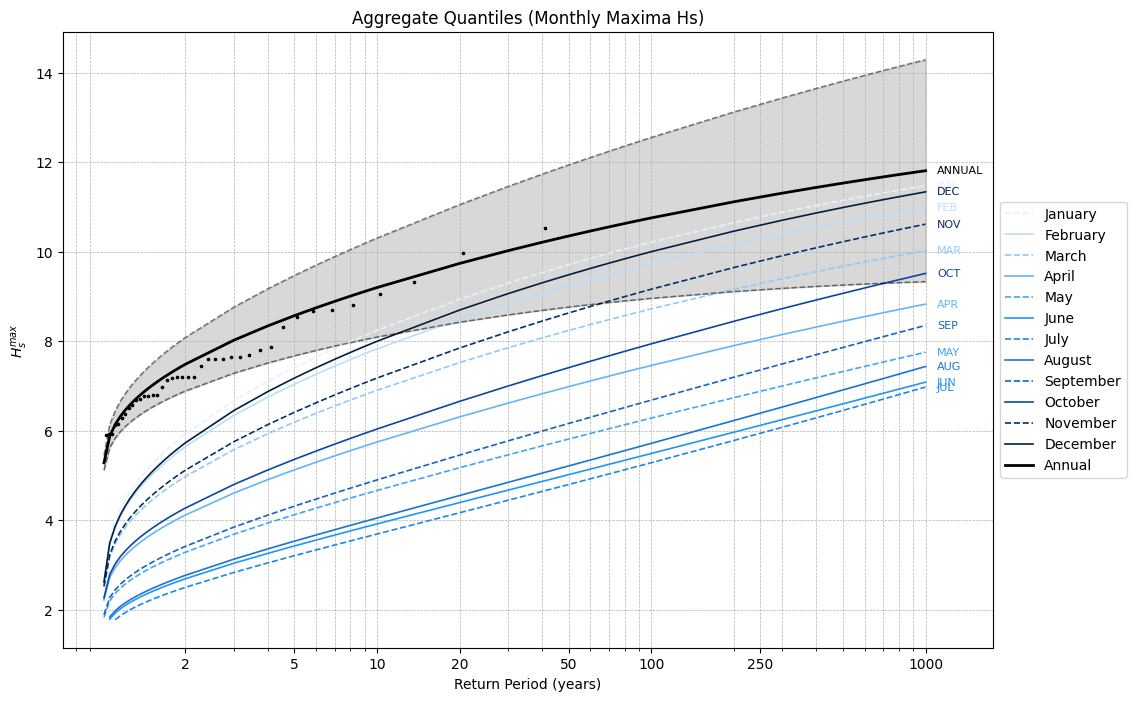

In [318]:
ReturnPeriodPlot(final_parameters)

#### Paso 3: Corrección de los extremos anuales

In [307]:
hsmax_corrected = np.zeros(ecdf_ev_probs.size)
for j in range(ecdf_ev_probs.size):
    hsmax_corrected[j] = _aggquantile(ecdf_ev_probs[j], 0, 1, final_parameters)[0]

In [311]:
hsmax_sort_mm = np.sort(hsmax_data['Hs'].values)

hs_corrected = hspt.copy()
for block_idx, max_value in enumerate(hsmax_sort_mm):
    if block_idx >= len(hsmax)-1:
        hs_corrected[hspt >= hsmax_sort_mm[-1]] = hsmax_corrected[-1]
        break
    else:
        for idx, daily_value in enumerate(hspt):
            if daily_value >= hsmax_sort_mm[block_idx] and daily_value < hsmax_sort_mm[block_idx+1]:
                hs_corrected[idx] = hsmax_corrected[block_idx]+((daily_value-hsmax_sort_mm[block_idx])/(hsmax_sort_mm[block_idx+1]-hsmax_sort_mm[block_idx]))*(hsmax_corrected[block_idx+1]-hsmax_corrected[block_idx])

##### Aggregated CDF

In [312]:
def GEVCDF_aggr(zq, t0, t1, coeffs):
    # Obtain coefficients
    beta0 = np.asarray(coeffs['beta0'])
    beta = np.asarray(coeffs['beta'])

    alpha0 = np.asarray(coeffs['alpha0'])
    alpha = np.asarray(coeffs['alpha'])

    gamma0 = np.asarray(coeffs['gamma0'])
    gamma = np.asarray(coeffs['gamma'])

    zq = np.array([zq])
    t0 = np.array([t0])
    t1 = np.array([t1])
    q = np.zeros(zq.size)

    for il in range(zq.size):
        integ, _ = quad(lambda x: _fzeroquanint(x,zq,0,beta0,beta,alpha0,alpha,gamma0,gamma), float(t0[il]), float(t1[il]))
        q[il] = np.exp(-12*integ)
    
    return q

In [315]:
x_values_gev = np.linspace(hsmax_sort_mm[0], hsmax_sort_mm[-1], 1000)
return_perd_values_gev = np.zeros(x_values_gev.size)
for j in range(x_values_gev.size):
    return_perd_values_gev[j] = 1/(1-GEVCDF_aggr(x_values_gev[j], t0=0, t1=1, coeffs=final_parameters))[0]

ecdf_ev_probs_corrected = np.zeros(ecdf_ev_probs.size)
T_ev_corrected = np.zeros(ecdf_ev_probs.size)
for i in range(ecdf_ev_probs.size):
    ecdf_ev_probs_corrected[i] = GEVCDF_aggr(_aggquantile(ecdf_ev_probs[i],0,1,final_parameters)[0],0,1,final_parameters)[0]
    T_ev_corrected[i] = 1/(1-ecdf_ev_probs_corrected[i])

ecdf_pt_probs_corrected = np.arange(1,len(hs_corrected)+1)/(len(hs_corrected)+1)
T_pt_corrected = 1/(1-ecdf_pt_probs_corrected)/n_return_period

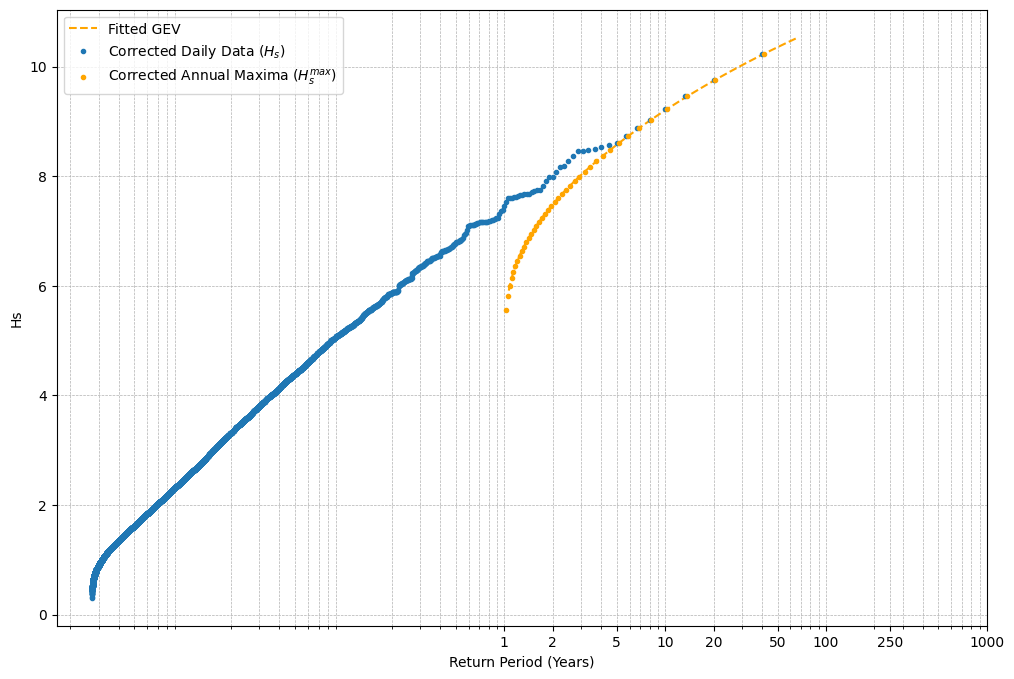

In [316]:
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()
#T_pt, np.sort(hspt)
#ax.semilogx(T_pt, np.sort(hspt), linewidth=1,markersize=1.5)
ax.semilogx(return_perd_values_gev, np.sort(x_values_gev), color = 'orange',linestyle='dashed', label='Fitted GEV')

# Datos corregidos
ax.semilogx(T_pt_corrected, np.sort(hs_corrected), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($H_s$)')
quanaggr_corrected = np.zeros(T_ev_corrected.size)
for i in range(ecdf_ev_probs.size):
    quanaggr_corrected[i] = _aggquantile(ecdf_ev_probs[i], 0,1,final_parameters)[0]
ax.semilogx(T_ev_corrected, quanaggr_corrected, color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima ($H_s^{max}$)')

# Sin corregir
# ax.semilogx(T_pt, np.sort(hspt), linewidth=0, color='purple', marker='o',markersize=1.5, label='Daily Data ($H_s$)', alpha=0.6)
# ax.semilogx(T_ev, np.sort(hsmax), color = 'green',linewidth=0, marker='o',markersize=1.5, label=r'Annual Maxima ($H_s^{max}$)', alpha=0.6)

ax.set_xlabel('Return Period (Years)')
ax.set_ylabel('Hs')
# Configurar escala logarítmica y ticks personalizados
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Mantiene los números sin notación científica

# Etiquetas y grid
ax.set_xlabel('Return Period (Years)')
ax.set_ylabel('Hs')
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Mostrar gráfico
plt.legend()
#plt.savefig("Figuras/corrected_return_periods.png", dpi=200)
plt.show()

#### Paso 4: Corrección de los extremos mensuales

In [ ]:
# Monthly maxima
hsmax_data_mm = df_hs.groupby(["yyyy","mm"], as_index=False)["Hs"].max()['Hs'].values
max_idx_mm = df_hs.groupby(["yyyy", "mm"])["Hs"].idxmax().values
n_return_period_mm = 365.25/12

In [325]:
hsmax_df = df_hs.groupby(["yyyy","mm"], as_index=False)["Hs"].max()

Maximmos mensuales divididos por mes

In [331]:
hsmax_per_month = {}
for i in range(12):
    hsmax_per_month[i+1] = hsmax_df[hsmax_df['mm'] == i+1]['Hs'].values

Periodos de retorno empíricos divididos por mes

In [372]:
ecdf_ev_probs_mm_per_month = {}
T_ev_mm_per_month = {}
for i in range(12):
    ecdf_ev_probs_mm_per_month[i+1] = np.arange(1,len(hsmax_per_month[i+1])+1)/(len(hsmax_per_month[i+1])+1)
    T_ev_mm_per_month[i+1] = 1/(1-ecdf_ev_probs_mm_per_month[i+1])

Corregir maximos mensuales para cada mes

In [373]:
hsmax_corrected_per_month = {}
for month in range(12):
    hsmax_corrected_per_month[month+1] = np.zeros(ecdf_ev_probs_mm_per_month[month+1].size)
    for j in range(ecdf_ev_probs_mm_per_month[month+1].size):
        hsmax_corrected_per_month[month+1][j] = _aggquantile(ecdf_ev_probs_mm_per_month[month+1][j], month/12, (month+1)/12, final_parameters)[0]

Ordenar los máximos empíricos

In [374]:
hsmax_sort_mm_per_month = {}
for month in range(12):
    hsmax_sort_mm_per_month[month+1] = np.sort(hsmax_per_month[month+1])

Corrección de los datos diarios en cada mes

In [356]:
hs_corrected_per_month = {}
for month in range(12):
    hs_corrected_per_month[month+1] = df_hs[df_hs['mm'] == month+1]['Hs'].values.copy()
    for block_idx, max_value in enumerate(hsmax_sort_mm_per_month[month+1]):
        if block_idx >= len(hsmax)-1:
            hs_corrected_per_month[month+1][df_hs[df_hs['mm'] == month+1]['Hs'].values >= hsmax_sort_mm_per_month[month+1][-1]] = hsmax_corrected_per_month[month+1][-1]
            break
        else:
            for idx, daily_value in enumerate(df_hs[df_hs['mm'] == month+1]['Hs'].values):
                if daily_value >= hsmax_sort_mm_per_month[month+1][block_idx] and daily_value < hsmax_sort_mm_per_month[month+1][block_idx+1]:
                    hs_corrected_per_month[month+1][idx] = hsmax_corrected_per_month[month+1][block_idx]+((daily_value-hsmax_sort_mm_per_month[month+1][block_idx])/(hsmax_sort_mm_per_month[month+1][block_idx+1]-hsmax_sort_mm_per_month[month+1][block_idx]))*(hsmax_corrected_per_month[month+1][block_idx+1]-hsmax_corrected_per_month[month+1][block_idx])

In [375]:
x_values_gev_per_month = {}
return_perd_values_gev_per_month = {}

ecdf_ev_probs_corrected_per_month ={}
T_ev_corrected_per_month = {}
ecdf_pt_probs_corrected_per_month = {}
T_pt_corrected_per_month = {}

for month in range(12):
    x_values_gev_per_month[month+1] = np.linspace(hsmax_sort_mm[0], hsmax_sort_mm[-1], 1000)
    return_perd_values_gev_per_month[month+1] = np.zeros(x_values_gev_per_month[month+1].size)
    for j in range(x_values_gev_per_month[month+1].size):
        return_perd_values_gev_per_month[month+1][j] = 1/(1-GEVCDF_aggr(x_values_gev_per_month[month+1][j], t0=month/12, t1=(month+1)/12, coeffs=final_parameters))[0]

    ecdf_ev_probs_corrected_per_month[month+1] = np.zeros(ecdf_ev_probs_mm_per_month[month+1].size)
    T_ev_corrected_per_month[month+1] = np.zeros(ecdf_ev_probs_mm_per_month[month+1].size)
    for i in range(ecdf_ev_probs_mm_per_month[month+1].size):
        ecdf_ev_probs_corrected_per_month[month+1][i] = GEVCDF_aggr(_aggquantile(ecdf_ev_probs_mm_per_month[month+1][i],month/12,(month+1)/12,final_parameters)[0],month/12,(month+1)/12,final_parameters)[0]
        T_ev_corrected_per_month[month+1][i] = 1/(1-ecdf_ev_probs_corrected_per_month[month+1][i])

    ecdf_pt_probs_corrected_per_month[month+1] = np.arange(1,len(hs_corrected_per_month[month+1])+1)/(len(hs_corrected_per_month[month+1])+1)
    T_pt_corrected_per_month[month+1] = 1/(1-ecdf_pt_probs_corrected_per_month[month+1])/n_return_period_mm

C:\Users\user\AppData\Local\Temp\ipykernel_10032\518556548.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integ, _ = quad(lambda x: _fzeroquanint(x,zq,0,beta0,beta,alpha0,alpha,gamma0,gamma), float(t0[il]), float(t1[il]))


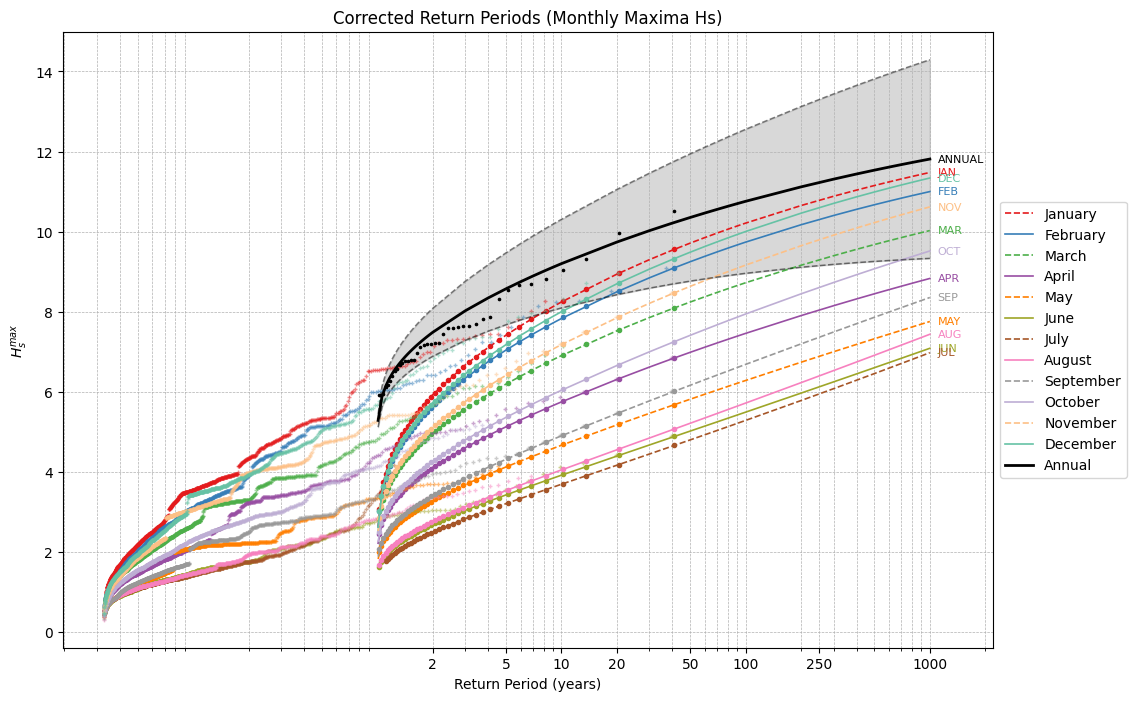

In [389]:
t = np.asarray(t)
xt = np.asarray(xt)
quanval=0.95
annualplot = True


# Ts = np.array([2, 5, 10, 20, 25, 50, 75, 100, 200, 300, 400, 500, 1000])
Ts = np.concatenate((np.arange(1.01,2,0.05), np.arange(2, 10, 1), np.arange(10, 100, 10), np.arange(100, 1001, 100)))

nts = len(Ts)
quanaggrA = np.zeros(nts)
quanaggr = np.zeros((12,nts))
# stdDqX = np.zeros((12,nts))   # Confidence interval for months
for i in range(12):
    for j in range(nts):
        quanaggr[i,j] = _aggquantile(1-1/Ts[j], i/12, (i+1)/12, final_parameters)[0]
        # stdQuan = _ConfidInterQuanAggregate(1-1/Ts[j], i/12, (i+1)/12, final_parameters)    # Confidence interval for months
        # stdDqX[i,j] = stdQuan*stats.norm.ppf(1-(1-quanval)/2, loc=0, scale=1)     # Confidence interval for months
    

# If annual data has to be plotted, compute the annual return period
if annualplot:
    for j in range(nts):
        quanaggrA[j] = _aggquantile(1-1/Ts[j], 0, 1, final_parameters)[0]
    # Confidence intervals
    stdup = np.zeros(nts)
    stdlo = np.zeros(nts)
    for i in range(nts):
        stdQuan = _ConfidInterQuanAggregate(1-1/Ts[i], 0, 1, final_parameters)
        #stdQuan = 0.1
        stdup[i] = quanaggrA[i]+stdQuan*stats.norm.ppf(1-(1-quanval)/2, loc=0, scale=1)
        stdlo[i] = quanaggrA[i]-stdQuan*stats.norm.ppf(1-(1-quanval)/2, loc=0, scale=1)


# Calculo de los extremos corregidos por mes (periodo de retorno para cada mes)
quanaggr_corrected_per_month = {}
for month in range(12):
    quanaggr_corrected_per_month[month+1] = np.zeros(T_ev_corrected_per_month[month+1].size)
    for i in range(ecdf_ev_probs.size):
        quanaggr_corrected_per_month[month+1][i] = _aggquantile(ecdf_ev_probs_corrected_per_month[month+1][i], month/12,(month+1)/12,final_parameters)[0]

## Plot the monthly return periods 
datemax_mod = t % 1
labels = ['January','February','March','April','May','June','July','August','September','October','November','December']
short_labels = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
colors = ["#E3F2FD", "#BBDEFB", "#90CAF9", "#64B5F6", "#42A5F5", "#2196F3", "#1E88E5", "#1976D2", "#1565C0", "#0D47A1", "#08306B", "#041E42"]
colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#9ea628", "#a65628", "#f781bf", "#999999", "#beaed4", "#fdc086", "#66c2a5"]
plt.figure(figsize=(12,8))
for i in range(12):
    ls = '-' if i % 2 == 1 else '--'
    plt.semilogx(Ts, quanaggr[i, :], color=colors[i], linestyle=ls, linewidth=1.2, label=labels[i])                                             # GEV fitted por mes
    plt.semilogx(T_ev_corrected_per_month[i+1], quanaggr_corrected_per_month[i+1], color = colors[i],linewidth=0, marker='o',markersize=3)      # Extremos corregidos
    plt.semilogx(T_pt_corrected_per_month[i+1], np.sort(hs_corrected_per_month[i+1]), color = colors[i], linewidth=0, marker='+',markersize=3, alpha = 0.5) # Extremos diarios corregidos



# Anual return periods  
if annualplot:
    plt.semilogx(Ts,quanaggrA, color="black", linewidth=2, label="Annual")
    t0_data = np.floor(t[0])
    ny = int(np.ceil(t[-1]))
    hmax1 = []
    for j in range(ny):
        mask = (t >= t0_data + j) & (t < t0_data + j + 1)
        if not np.any(mask):
            hmax1.append(np.nan)
        else:
            hmax1.append(np.max(xt[mask]))
    hmax1 = np.array(hmax1)[~np.isnan(hmax1)]
    hmaxsort = np.sort(hmax1)

    # hmaxsort = np.sort(xt)
    ProHsmaxsort = np.arange(1, len(hmaxsort) + 1) / (len(hmaxsort) + 1)
    Tapprox = 1/(1-ProHsmaxsort)
    idx = np.where(Tapprox >= Ts[0])[0]
    plt.semilogx(Tapprox[idx],hmaxsort[idx],'ok', markersize=1.6)
    plt.semilogx(Ts, stdlo, '--k', linewidth=1.1, alpha = 0.5)
    plt.semilogx(Ts, stdup, '--k', linewidth=1.1, alpha = 0.5)
    plt.fill_between(Ts, stdlo, stdup, color='gray', alpha=0.3)


# Ajusta factor_x si quieres desplazar más (o menos) a la derecha
factor_x = 1.1  
x_text = Ts[-1] * factor_x  

# Etiquetas mensuales
for i in range(12):
    y_text = quanaggr[i, -1]  # último valor de la curva i
    plt.text(x_text, y_text,
                short_labels[i],
                color=colors[i],
                ha='left',
                va='center',
                fontsize=8)

# Etiqueta de la curva anual
if annualplot:
    y_text_annual = quanaggrA[-1]
    plt.text(x_text, y_text_annual,
                "ANNUAL",
                color="black",
                ha='left',
                va='center',
                fontsize=8)

plt.xlabel("Return Period (years)")
plt.ylabel(r"$H_s^{max}$")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ticks = [2, 5, 10, 20, 50, 100, 250, 1000]
plt.xticks(ticks,ticks)
plt.xlim(right=Ts[-1]*factor_x*2)
# plt.xlim(left=0,right=Ts[-1]+50)
# plt.ylim(bottom=0)
plt.title(f"Corrected Return Periods (Monthly Maxima Hs)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.margins(x=0.1)
plt.savefig(f"Figuras/monthly_corrected_return_periods.png", dpi=200)
plt.show()

# Corrección Extremos por Weather Types

Extraer máximos anuales de cada WT

#### Paso 1: Ajustar una ÚNICA GEV con covariables (PCs) para los máximos anuales 

In [ ]:
from Daily_Hs_StormSurge_ScipyJax.non_stationary_model import NonStationaryModel
import jax.numpy as jnp
import time

xt = hsmax_data_mm
t = Hsdata.to_numpy()[max_idx_mm,-1]

# 1. Definición de los datos
xt=jnp.array(xt)
t =jnp.array(t)

# Covariables (PCs)
covariate_loc = jnp.asarray()
covariate_sc = jnp.asarray()
covariate_sh = jnp.asarray()


# Parámetros iniciales
n_harmonics_loc = 0     # Número de armónicos para ubicación
n_harmonics_scale = 0   # Número de armónicos para escala
n_harmonics_shape = 0   # Número de armónicos para forma
betaT = 0               # Tendencia en localización
betaT2 = 0              # Tendencia en escala
# rhocoeff = 6000  # Coeficiente de penalización Lasso


model_lasso = NonStationaryModel(
    xt=xt,
    t=t,
    covariates_loc=jnp.empty((len(xt),0)),
    covariates_sc=jnp.empty((len(xt),0)),
    covariates_sh=jnp.empty((len(xt),0)),
    n_harmonics_loc=n_harmonics_loc,
    n_harmonics_scale=n_harmonics_scale,
    n_harmonics_shape=n_harmonics_shape,
    betaT=betaT,
    betaT2=betaT2,
    #rhocoeff=rhocoeff,
    regularization_type="lasso",
    example='Monthly Maxima Hs'
)

In [ ]:
print("Ajustando modelo con regularización Lasso...")
# Iniciar el temporizador
start_time = time.time()
result_lasso = model_lasso.fit(rhocoeff=0, method='lbfgsb', maxiter=1000, linesearch='zoom')  # linesearch='hager-zhang', 'zoom', 'backtracking'
# Detener el temporizador
end_time = time.time()
# Calcular el tiempo transcurrido
elapsed_time = end_time - start_time
print(f"Tiempo de ejecución L-BFGS-B Grid Search con lasso: {elapsed_time:.2f} segundos")
print("Ajuste completado.\n")

# 9. Obtener y mostrar parámetros ajustados para Lasso
print(f"Valor óptimo de verosimilitud: {result_lasso['loglik']}")
print("\nParámetros ajustados con Lasso:")
model_lasso.summary()

final_parameters = result_lasso['params']

In [ ]:
model_lasso.PPplot()
model_lasso.QQplot()

#### Paso 2: Obtener bloques para la transformación

In [ ]:
def _parametro(alpha0=None,alpha=None,betaT=None,varphi=None,covariates=None,indicesint=None,x=None):
    """
    This function computes the location, scale and shape parameters for given parameters. Expressions by (2)-(3) in the paper

    Inputs:
    - alpha0: Value of the intercept
    - alpha: Value of the harmonics terms
    - betaT: tendency for the location parameter, just need to include a number in order to consider it, otherwise leave it empty
    - covariates: Covariates data related to the location parameter, a matrix including the data at time t for each covariate
    - varphi: covariate parameter vector associated with the location parameter, just need to include a list of numbers of length the number of covariates, otherwise leave it empty
    - indicesint: covariate mean values in the integral interval
    - times: times when covariates are known, nearest value (function _search)

    Output:
    - y: values of the parameter
    """

    if betaT is None:
        betaT = 0

    t = np.array([x])

    harmonic_terms_mu = np.sum(np.array([
        alpha[2*k] * np.cos((k+1) * 2 * np.pi * t) +
        alpha[2*k + 1] * np.sin((k+1) * 2 * np.pi * t)
        for k in range(len(alpha)//2)
    ]), axis=0)

    mu = alpha0 + harmonic_terms_mu + betaT * t + jnp.dot(covariates, varphi)


    # Adding the covariate part
    # if nind > 0:
    #     if indicesint.shape[1] > 0:
    #         if times.shape[1] == 0:
    #             for i in range(nind):
    #                 y += varphi[i]*indicesint[i]
    #         else:
    #             for i in range(nind):
    #                 indicesintaux = self._search(times, covariates[:,i])
    #                 y += varphi[i]*indicesintaux
    #     else:
    #         for i in range(nind):
    #             y += varphi[i]*covariates[:,i]

    
            
    return np.asarray(mu).flatten()

In [ ]:
def _fzeroquanint(t,zq,q,beta0,beta,alpha0,alpha,gamma0,gamma,varphi,varphi2,varphi3):
    """
    Function to solve the quantile
    """
    
    # Evaluate the location parameter at each time t as a function of the actual values of the parameters given by p
    mut1 = _parametro(beta0, beta,None,varphi,covariate_loc,None,t)
    # Evaluate the scale parameter at each time t as a function of the actual values of the parameters given by p
    psit1 = np.exp(_parametro(alpha0, alpha,None,varphi2,covariate_sc,None,t))
    # Evaluate the sahpe parameter at each time t as a function of the actual values of the parameters given by p
    epst = _parametro(gamma0,gamma, None,varphi3,covariate_sh,None,t)

    # The values whose shape parameter is almost cero corresponds to the GUMBEL distribution, locate their positions if they exist
    posG = np.where(np.abs(epst) <= 1e-8)[0]
    # The remaining values correspond to WEIBULL or FRECHET
    pos = np.where(np.abs(epst) > 1e-8)[0]
    # The corresponding GUMBEl values are set to 1 to avoid numerical problems, note that for those cases the GUMBEL expressions are used
    epst[posG] = 1

    kt = np.ones(len(mut1))

    mut = mut1
    psit = psit1
    mut[pos] = mut1[pos] + psit1[pos] * (kt[pos] ** epst[pos] - 1) / epst[pos]
    psit[pos] = psit1[pos] * kt[pos] ** epst[pos]
    # Modify the parameters to include Gumbel
    mut[posG] += psit[posG] * np.log(kt[posG])

    # Evaluate the auxiliary variable
    xn = (zq-mut)/psit
    z = 1+epst*xn
    # Since the z-values must be greater than zero in order to avoid numerical problems their values are set to be greater than 1e-4
    z = np.maximum(1e-4,z)
    zn = z**(-1/epst)

    # GUMBEL case
    zn[posG] = np.exp(-xn[posG])

    return zn

In [ ]:
def _fzeroderiquanint(t,zq,q,beta0,beta,alpha0,alpha,gamma0,gamma,varphi,varphi2,varphi3):
    """
    Function to solve the quantile
    """
    # Evaluate the location parameter at each time t as a function of the actual values of the parameters given by p
    mut1 = _parametro(beta0, beta,None,varphi,covariate_loc,None,t)
    # Evaluate the scale parameter at each time t as a function of the actual values of the parameters given by p
    psit1 = np.exp(_parametro(alpha0, alpha,None,varphi2,covariate_sc,None,t))
    # Evaluate the sahpe parameter at each time t as a function of the actual values of the parameters given by p
    epst = _parametro(gamma0,gamma, None,varphi3,covariate_sh,None,t)

    # The values whose shape parameter is almost cero corresponds to the GUMBEL distribution, locate their positions if they exist
    posG = np.where(np.abs(epst) <= 1e-8)[0]
    # The remaining values correspond to WEIBULL or FRECHET
    pos = np.where(np.abs(epst) > 1e-8)[0]
    # The corresponding GUMBEl values are set to 1 to avoid numerical problems, note that for those cases the GUMBEL expressions are used
    epst[posG] = 1

    kt = np.ones(len(mut1))

    mut = mut1
    psit = psit1
    mut[pos] = mut1[pos] + psit1[pos] * (kt[pos] ** epst[pos] - 1) / epst[pos]
    psit[pos] = psit1[pos] * kt[pos] ** epst[pos]
    # Modify the parameters to include Gumbel
    mut[posG] += psit[posG] * np.log(kt[posG])

    # Evaluate the auxiliary variable
    xn = (zq-mut)/psit
    z = 1+epst*xn
    # Since the z-values must be greater than zero in order to avoid numerical problems their values are set to be greater than 1e-4
    z = np.maximum(1e-4,z)
    zn = -z**(-1-1/epst)/psit
    # GUMBEL case
    zn[posG] = -np.exp(-xn[posG])/psit[posG]

    return zn    

In [ ]:
from scipy.integrate import quad

def _aggquantile(q, t0, t1, coeffs):
    """
    Function to compute the aggregated quantile for certain parameters
    """
    # Obtain coefficients
    beta0 = np.asarray(coeffs['beta0'])
    beta = np.asarray(coeffs['beta'])
    betaT = np.asarray(coeffs['betaT'])
    varphi = np.asarray(coeffs['varphi'])

    alpha0 = np.asarray(coeffs['alpha0'])
    alpha = np.asarray(coeffs['alpha'])
    betaT2 = np.asarray(coeffs['betaT2'])
    varphi2 = np.asarray(coeffs['varphi2'])

    gamma0 = np.asarray(coeffs['gamma0'])
    gamma = np.asarray(coeffs['gamma'])
    varphi3 = np.asarray(coeffs['varphi3'])

    q = np.array([q])
    t0 = np.array([t0])
    t1 = np.array([t1])
    m = len(q)
    m0 = len(t0)
    m1 = len(t1)
    if m != m0:
        ValueError("Initial quantile aggregated integration time size must be equal than the quantile size")
    if m != m1:
        ValueError("Final quantile aggregated integration time size must be equal than the quantile size")

    # Require quantile
    zqout = np.zeros(m)
    

    media, _ = quad(lambda x: _parametro(beta0,beta,x).item(), 0,1)
    #std, _ = quad(lambda x: np.exp(_parametro(alpha0,alpha,x).item()), 0,1)

    for il in range(m):
        #for jl in range(n)
        zq = media
        err = 1
        iter = 1
        while err > 1e-4 and iter < 1000:
            zqold = zq
            integ, _ = quad(lambda x: _fzeroquanint(x,zqold,q[il],beta0,beta,alpha0,alpha,gamma0,gamma,varphi,varphi2,varphi3),float(t0[il]),float(t1[il]))
            integ += np.log(q[il])/12#*(float(t1[il])-float(t0[il]))
            dint, _ = quad(lambda x: _fzeroderiquanint(x,zqold,q[il],beta0,beta,alpha0,alpha,gamma0,gamma,varphi,varphi2,varphi3),float(t0[il]),float(t1[il]))
            zq += -integ/dint
            if np.abs(zqold) > 1e-5:
                err = np.abs((zq-zqold)/zqold)
            else:
                err = np.abs(zq-zqold)
            # print(zq)
            iter += 1
        if iter == 1000:
            zq = np.nan
            Warning("Maximum number of Newton iterations")
        if integ > 1e-2:
            zq = np.nan
            Warning("False zero, check it")
        zqout[il] = zq
        
    return zqout

In [ ]:
def loglikelihood(params):
    """
    Define el modelo no estacionario.

    Args:
        params (jnp.array): Parámetros del modelo.

    Returns:
        jnp.array: Log-verosimilitud del modelo.
    """
    # Extraer parámetros
    beta0 = params['beta0']
    beta = params['beta']
    betaT = params['betaT']
    varphi = params['varphi']

    alpha0 = params['alpha0']
    alpha = params['alpha'] 
    betaT2 = params['betaT2']
    varphi2 = params['varphi2']

    gamma0 = params['gamma0']
    gamma = params['gamma'] 
    varphi3 = params['varphi3']

    # Cálculos de mu, sigma, xi
    harmonic_terms_mu = jnp.sum(jnp.array([
        beta[2*k] * jnp.cos((k+1) * 2 * jnp.pi * t) +
        beta[2*k + 1] * jnp.sin((k+1) * 2 * jnp.pi * t)
        for k in range(beta.size)
    ]), axis=0)
    mu = beta0 + harmonic_terms_mu + betaT * t + jnp.dot(covariate_loc, varphi)

    harmonic_terms_sigma = jnp.sum(jnp.array([
        alpha[2*k] * jnp.cos((k+1) * 2 * jnp.pi * t) +
        alpha[2*k + 1] * jnp.sin((k+1) * 2 * jnp.pi * t)
        for k in range(alpha.size)
    ]), axis=0)
    sigma = jnp.maximum(1e-5, jnp.exp(alpha0 + harmonic_terms_sigma + betaT2 * t + jnp.dot(covariate_sc, varphi2)))
    #sigma = jnp.exp(alpha0 + harmonic_terms_sigma + betaT2 * self.t + jnp.dot(self.covariates_sc, varphi2))

    harmonic_terms_xi = jnp.sum(jnp.array([
        gamma[2*k] * jnp.cos((k+1) * 2 * jnp.pi * t) +
        gamma[2*k + 1] * jnp.sin((k+1) * 2 * jnp.pi * t)
        for k in range(gamma.size)
    ]), axis=0)
    xi = gamma0 + harmonic_terms_xi + jnp.dot(covariate_sh, varphi3)

    xn = (xt - mu) / sigma
    z = 1 + xi * xn
    z = jnp.maximum(z, 1e-8)

    # Gumbel version (xi close to 0)
    loglik_gumbel = jnp.where(
        jnp.abs(xi) < 1e-8,
        jnp.log(sigma) + xn + jnp.exp(-xn),
        0.0  # Para los que no cumplen la condición
    )

    # General version (xi != 0)
    loglik_general = jnp.where(
        jnp.abs(xi) >= 1e-8,
        jnp.log(sigma) +
        (1 + 1 / xi) * jnp.log(z) +
        z ** (-1 / xi),
        0.0  # Para los que no cumplen la condición
    )

    # Combine the results
    loglik = jnp.sum(loglik_gumbel) + jnp.sum(loglik_general)

    return -loglik

In [ ]:
from jax.flatten_util import ravel_pytree
import jax

flat_params, unravel_fn = ravel_pytree(final_parameters)

def loglik_fn_for_hessian(flat):
    # Convertimos flat en la estructura original
    original_params = unravel_fn(flat)
    return loglikelihood(original_params)


def hessian_loglik(flat_params):
    """
    Calcula la Hessiana de _loglikelihood en los parámetros 'params'.
    """
    # Calculamos la Hessiana con jax
    H = jax.hessian(loglik_fn_for_hessian)(flat_params)
    return H

In [ ]:
hess = hessian_loglik(flat_params)
invI0 = jnp.linalg.inv(-hess)

In [ ]:
def _ConfidInterQuanAggregate(q, t0, t1, coeffs):
    """
    Auxiliar function to compute the std for the aggregated quantiles
    """
    # Obtain coefficients
    beta0 = np.asarray(coeffs['beta0'])
    beta = np.asarray(coeffs['beta'])
    betaT = np.asarray(coeffs['betaT'])
    varphi = np.asarray(coeffs['varphi'])

    alpha0 = np.asarray(coeffs['alpha0'])
    alpha = np.asarray(coeffs['alpha'])
    betaT2 = np.asarray(coeffs['betaT2'])
    varphi2 = np.asarray(coeffs['varphi2'])

    gamma0 = np.asarray(coeffs['gamma0'])
    gamma = np.asarray(coeffs['gamma'])
    varphi3 = np.asarray(coeffs['varphi3'])
    
    # Total length of the data
    n = beta0.size + beta.size + betaT.size + varphi.size + alpha0.size + alpha.size + betaT2.size + varphi2.size + gamma0.size + gamma.size + varphi3.size

    # Initialize the Jacobian
    jacob = np.zeros(n)

    epsi = 1e-4

    # beta0 derivative
    aux = 0
    coeffs_beta0_1 = coeffs.copy()
    coeffs_beta0_2 = coeffs.copy()
    coeffs_beta0_2['beta0'] = beta0*(1+epsi)
    coeffs_beta0_1['beta0'] = beta0*(1-epsi)
    jacob[aux] = (_aggquantile(q,t0,t1,coeffs_beta0_2)[0]-_aggquantile(q,t0,t1,coeffs_beta0_1)[0])/(2*beta0*epsi)

    # beta derivatives
    if beta.size != 0:
        for i in range(beta.size):
            aux += 1
            coeffs_beta1 = coeffs.copy()
            coeffs_beta2 = coeffs.copy()
            coeffs_beta2['beta'] = coeffs_beta2['beta'].at[i].set(beta[i]*(1+epsi))
            coeffs_beta1['beta'] = coeffs_beta1['beta'].at[i].set(beta[i]*(1-epsi))
            jacob[aux] = (_aggquantile(q,t0,t1,coeffs_beta2)[0]-_aggquantile(q,t0,t1,coeffs_beta1)[0])/(2*beta[i]*epsi)

    # varphi derivative
    if varphi.size != 0:
        for i in range(varphi.size):
            aux += 1
            if np.abs(varphi[i]) < 1e-5:
                coeffs_varphi_1 = coeffs.copy()
                coeffs_varphi_2 = coeffs.copy()
                coeffs_varphi_2['varphi'] = coeffs_varphi_2['varphi'].at[i].set(varphi[i]*(1+epsi))
                coeffs_varphi_1['varphi'] = coeffs_varphi_1['varphi'].at[i].set(varphi[i]*(1-epsi))
                jacob[aux] = (_aggquantile(q,t0,t1,coeffs_varphi_2)[0]-_aggquantile(q,t0,t1,coeffs_varphi_1)[0])/(2*varphi[i]*epsi)
            else:
                jacob[aux] = 0

    # alpha0 derivative
    aux += 1
    coeffs_alpha0_1 = coeffs.copy()
    coeffs_alpha0_2 = coeffs.copy()
    coeffs_alpha0_2['alpha0'] = alpha0*(1+epsi)
    coeffs_alpha0_1['alpha0'] = alpha0*(1-epsi)
    jacob[aux] = (_aggquantile(q,t0,t1,coeffs_alpha0_2)[0]-_aggquantile(q,t0,t1,coeffs_alpha0_1)[0])/(2*alpha0*epsi)

    # alpha derivatives
    if alpha.size != 0:
        for i in range(alpha.size):
            aux += 1
            coeffs_alpha1 = coeffs.copy()
            coeffs_alpha2 = coeffs.copy()
            coeffs_alpha2['alpha'] = coeffs_alpha2['alpha'].at[i].set(alpha[i]*(1+epsi))
            coeffs_alpha1['alpha'] = coeffs_alpha1['alpha'].at[i].set(alpha[i]*(1-epsi))
            jacob[aux] = (_aggquantile(q,t0,t1,coeffs_alpha2)[0]-_aggquantile(q,t0,t1,coeffs_alpha1)[0])/(2*alpha[i]*epsi)

    # varphi2 derivative
    if varphi2.size != 0:
        for i in range(varphi2.size):
            aux += 1
            if np.abs(varphi2[i]) < 1e-5:
                coeffs_varphi2_1 = coeffs.copy()
                coeffs_varphi2_2 = coeffs.copy()
                coeffs_varphi2_2['varphi2'] = coeffs_varphi2_2['varphi2'].at[i].set(varphi2[i]*(1+epsi))
                coeffs_varphi2_1['varphi2'] = coeffs_varphi2_1['varphi2'].at[i].set(varphi2[i]*(1-epsi))
                jacob[aux] = (_aggquantile(q,t0,t1,coeffs_varphi2_2)[0]-_aggquantile(q,t0,t1,coeffs_varphi2_1)[0])/(2*varphi2[i]*epsi)
            else:
                jacob[aux] = 0

    # gamma0 derivative
    aux += 1 
    coeffs_gamma0_1 = coeffs.copy()
    coeffs_gamma0_2 = coeffs.copy()
    coeffs_gamma0_2['gamma0'] = gamma0*(1+epsi)
    coeffs_gamma0_1['gamma0'] = gamma0*(1-epsi)
    jacob[aux] = (_aggquantile(q,t0,t1,coeffs_gamma0_2)[0]-_aggquantile(q,t0,t1,coeffs_gamma0_1)[0])/(2*gamma0*epsi)

    if gamma.size != 0:
        for i in range(gamma.size):
            aux += 1
            coeffs_gamma1 = coeffs.copy()
            coeffs_gamma2 = coeffs.copy()
            coeffs_gamma2['gamma'] = coeffs_gamma2['gamma'].at[i].set(gamma[i]*(1+epsi))
            coeffs_gamma1['gamma'] = coeffs_gamma1['gamma'].at[i].set(gamma[i]*(1-epsi))
            jacob[aux] = (_aggquantile(q,t0,t1,coeffs_gamma2)[0]-_aggquantile(q,t0,t1,coeffs_gamma1)[0])/(2*gamma[i]*epsi)

    # varphi3 derivative
    if varphi3.size != 0:
        for i in range(varphi3.size):
            aux += 1
            if np.abs(varphi3[i]) < 1e-5:
                coeffs_varphi3_1 = coeffs.copy()
                coeffs_varphi3_2 = coeffs.copy()
                coeffs_varphi3_2['varphi3'] = coeffs_varphi3_2['varphi3'].at[i].set(varphi3[i]*(1+epsi))
                coeffs_varphi3_1['varphi3'] = coeffs_varphi3_1['varphi3'].at[i].set(varphi3[i]*(1-epsi))
                jacob[aux] = (_aggquantile(q,t0,t1,coeffs_varphi3_2)[0]-_aggquantile(q,t0,t1,coeffs_varphi3_1)[0])/(2*varphi3[i]*epsi)
            else:
                jacob[aux] = 0
    
    # Computing the standard deviations for the quantiles
    stdQuan = np.sqrt(jacob.T @ invI0 @ jacob)

    return stdQuan

#### Paso 3: Corrección de los extremos para cada WT

# Paper

## Plots asociados a las distribuciones empíricas

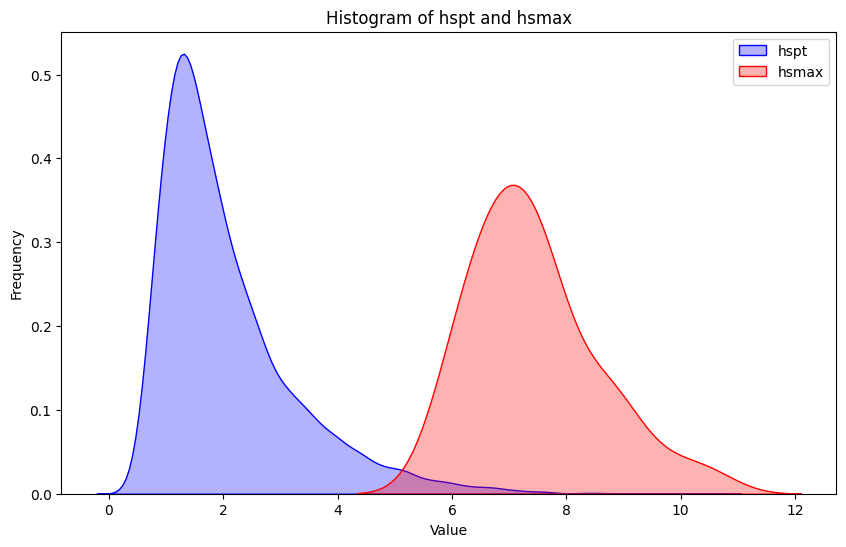

In [21]:
import seaborn as sns

plt.figure(figsize=(10,6))

sns.kdeplot(hspt, color="blue", label="hspt", fill=True, alpha=0.3)
sns.kdeplot(hsmax, color="red", label="hsmax", fill=True, alpha=0.3)

plt.legend()
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of hspt and hsmax")
plt.show()

## Obtaining xlim value from ECDF

In [22]:
def ecdf_pt(x):
    return np.searchsorted(np.sort(hspt), x, side='right') / len(np.sort(hspt))

def ecdf_ev(x):
    return np.searchsorted(np.sort(hsmax), x, side='right') / len(np.sort(hsmax))

In [23]:
from scipy.optimize import differential_evolution

def obj_fun(x):
    pt_t = 1/(1-ecdf_pt(x))
    ev_t = n_return_period/(1-ecdf_ev(x))
    return (pt_t-ev_t)**2

bounds = [(0.01, 10)]  

result = differential_evolution(obj_fun, bounds)
print("Global Min:", result.x, "Function Value:", result.fun)

Global Min: [8.78231204] Function Value: 1.258141711693155e-21


In [24]:
obj_fun(result.x)

array([1.25814171e-21])

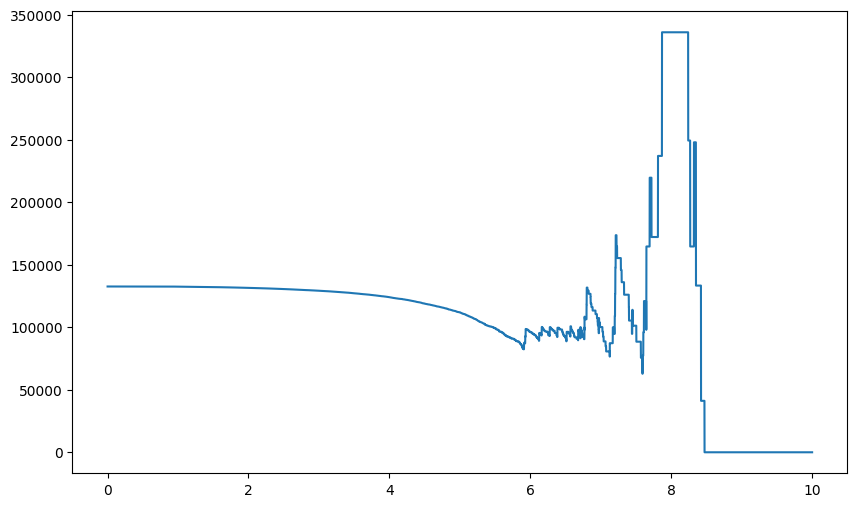

In [25]:
plt.figure(figsize=(10,6))
xrange = np.linspace(0,10, 100000)
plt.plot(xrange, obj_fun(xrange))
plt.show()

## Fitting Log-Normal distribution to complete series

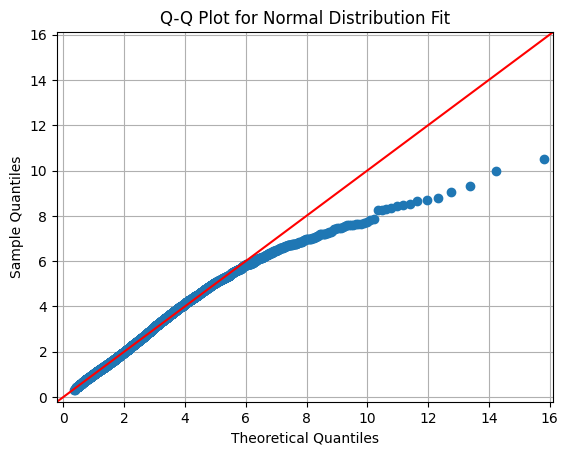

In [26]:
import scipy.stats as stats
import statsmodels.api as sm

shape, loc, scale = stats.lognorm.fit(hspt)


# Q-Q Plot
sm.qqplot(hspt, stats.lognorm, distargs=(shape,), loc=loc, scale=scale, line="45")
plt.title("Q-Q Plot for Normal Distribution Fit")
plt.grid()
plt.show()

In [27]:
shape, loc, scale

(0.6056942209548526, 0.20537479870316727, 1.5478525570785528)

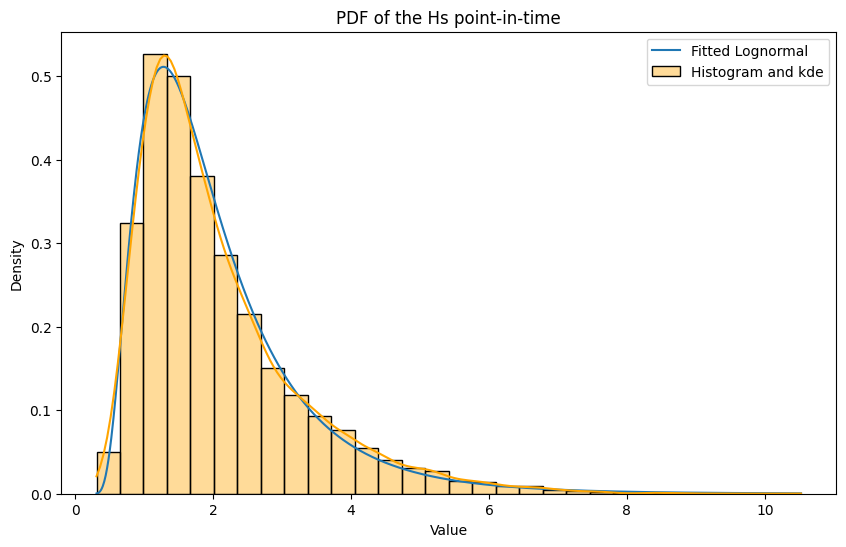

In [28]:
# Generate x values for density plot
x_values = np.linspace(min(hspt), max(hspt), 1000)
pdf_values = stats.lognorm.pdf(x_values, shape, loc=loc, scale=scale)

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(x_values, pdf_values, label="Fitted Lognormal")

# Histogram of the data (as density)
sns.histplot(hspt, bins=30, kde=True, stat="density", color="orange", alpha=0.4, label="Histogram and kde")

# Labels and title
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("PDF of the Hs point-in-time")
plt.legend()

# Show the plot
plt.show()

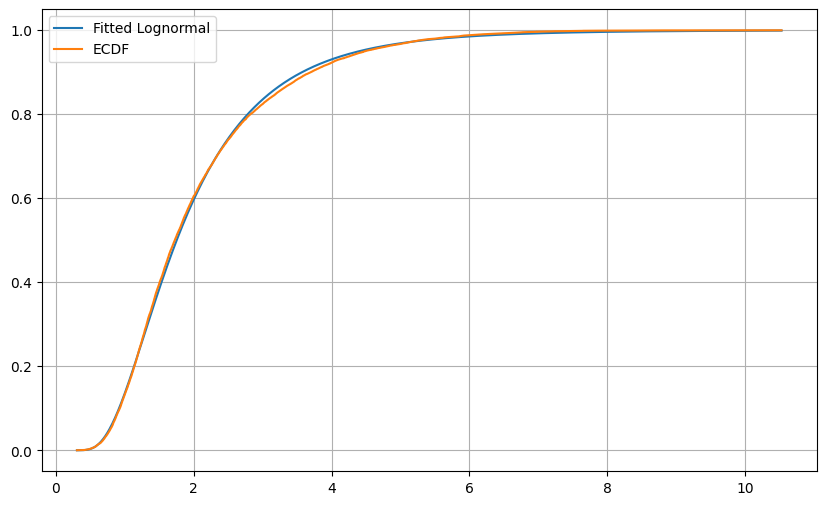

In [29]:
plt.figure(figsize=(10,6))
plt.plot(x_values, stats.lognorm.cdf(x_values, shape, loc=loc, scale=scale), label='Fitted Lognormal')
plt.plot(np.sort(hspt), ecdf_pt_probs, label='ECDF')
plt.grid()
plt.legend()
plt.show()

## Fitting GEV to extremes

In [30]:
shape_gev, loc_gev, scale_gev = stats.genextreme.fit(hsmax) 

In [31]:
shape_gev, loc_gev, scale_gev

(-0.03661367714795377, 6.918467262399817, 0.8294499796678392)

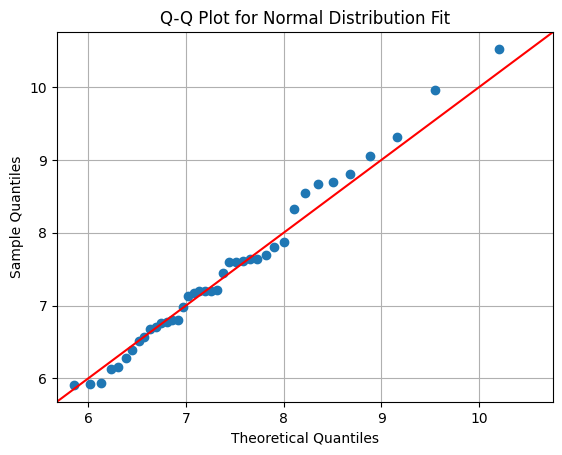

In [32]:
# Q-Q Plot
sm.qqplot(hsmax, stats.genextreme, distargs=(shape_gev,), loc=loc_gev, scale=scale_gev, line="45")
plt.title("Q-Q Plot for Normal Distribution Fit")
plt.grid()
plt.show()

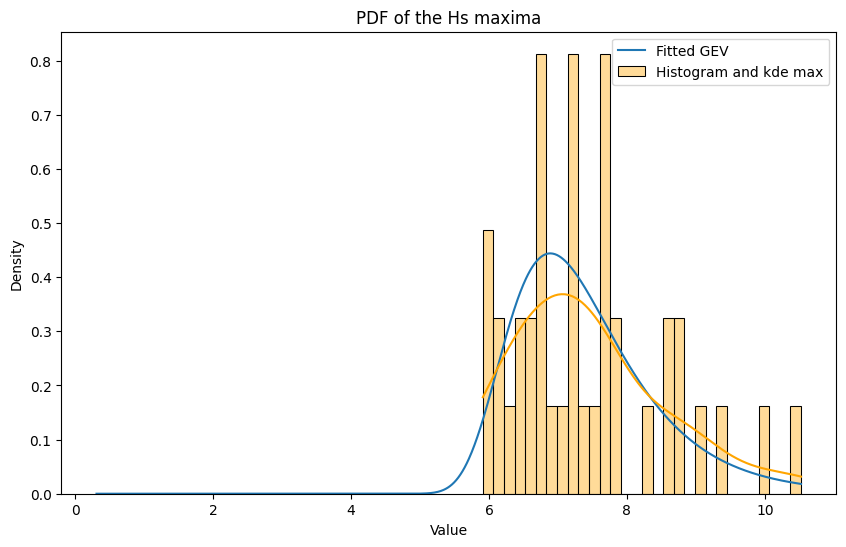

In [33]:
# Generate x values for density plot
x_values_gev = np.linspace(min(hsmax), max(hsmax), 1000)
pdf_values_gev = stats.genextreme.pdf(x_values, shape_gev, loc=loc_gev, scale=scale_gev)

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(x_values, pdf_values_gev, label="Fitted GEV")

# Histogram of the data (as density)
sns.histplot(hsmax, bins=30, kde=True, stat="density", color="orange", alpha=0.4, label="Histogram and kde max")

# Labels and title
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("PDF of the Hs maxima")
plt.legend()

# Show the plot
plt.show()

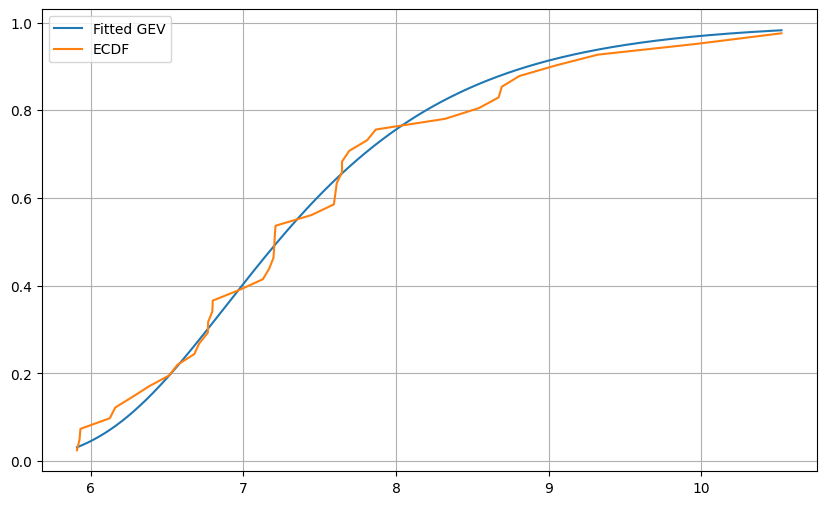

In [34]:
plt.figure(figsize=(10,6))
plt.plot(x_values_gev, stats.genextreme.cdf(x_values_gev, shape_gev, loc=loc_gev, scale=scale_gev), label='Fitted GEV')
plt.plot(np.sort(hsmax), ecdf_ev_probs, label='ECDF')
plt.grid()
plt.legend()
plt.show()

### Combining graphics for fitted distributions

#### PDF

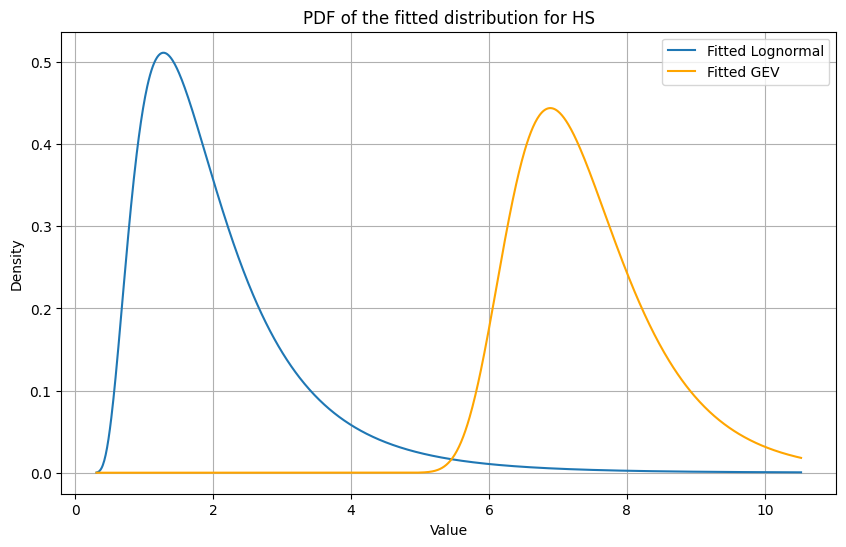

In [35]:
# Combining both pdf
# Generate x values for density plot
x_values_gev = np.linspace(min(hsmax), max(hsmax), 1000)
pdf_values_gev = stats.genextreme.pdf(x_values, shape_gev, loc=loc_gev, scale=scale_gev)
x_values = np.linspace(min(hspt), max(hspt), 1000)
pdf_values = stats.lognorm.pdf(x_values, shape, loc=loc, scale=scale)

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(x_values, pdf_values, label="Fitted Lognormal")
plt.plot(x_values, pdf_values_gev, color="orange", label="Fitted GEV")

# Histogram of the data (as density)
# sns.histplot(hspt, bins=30, kde=True, stat="density", color="orange", alpha=0.4, label="Histogram and kde")
# sns.histplot(hsmax, bins=30, kde=True, stat="density", color="orange", alpha=0.4, label="Histogram and kde max")

# Labels and title
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("PDF of the fitted distribution for HS")
plt.legend()
plt.grid()
# Show the plot
plt.show()

#### CDF

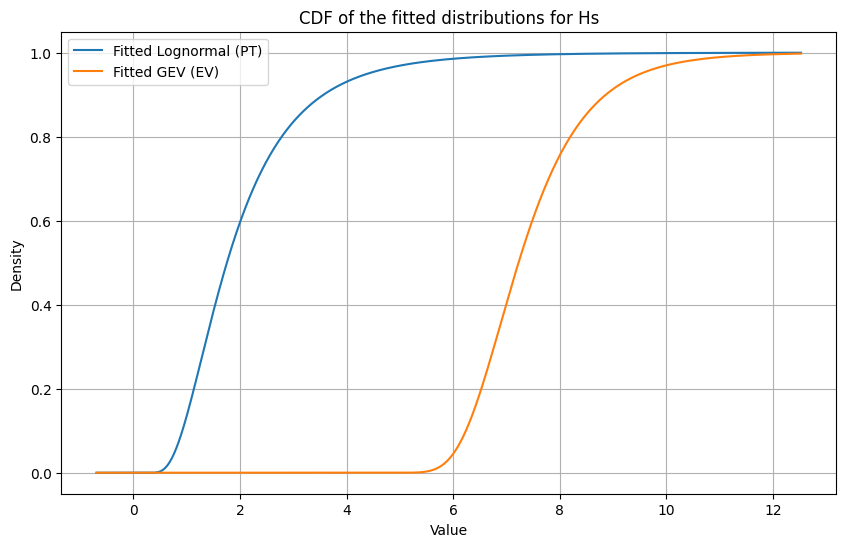

In [36]:
# Combining both pdf
# Generate x values for density plot
x_values_gev = np.linspace(min(hspt)-1, max(hspt)+2, 1000)
pdf_values_gev = stats.genextreme.pdf(x_values, shape_gev, loc=loc_gev, scale=scale_gev)
x_values = np.linspace(min(hspt)-1, max(hspt)+2, 1000)
pdf_values = stats.lognorm.pdf(x_values, shape, loc=loc, scale=scale)

# Create the plot
plt.figure(figsize=(10,6))
# plt.plot(x_values, pdf_values, color="blue", label="Fitted Lognormal", linewidth=2)
# plt.plot(x_values, pdf_values_gev, color="orange", label="Fitted GEV", linewidth=2)
plt.plot(x_values, stats.lognorm.cdf(x_values, shape, loc=loc, scale=scale), label='Fitted Lognormal (PT)')
plt.plot(x_values_gev, stats.genextreme.cdf(x_values_gev, shape_gev, loc=loc_gev, scale=scale_gev), label='Fitted GEV (EV)')


# Labels and title
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("CDF of the fitted distributions for Hs")
plt.legend()
plt.grid()
# Show the plot
plt.show()

Combined return periods of the fitted distributions

In [37]:
x_values_gev = np.linspace(min(hsmax), max(hspt), 1000)
return_perd_values_gev = n_return_period/(1-stats.genextreme.cdf(x_values, shape_gev, loc=loc_gev, scale=scale_gev))
x_values = np.linspace(min(hspt), max(hspt), 1000)
return_perd_values = 1/(1-stats.lognorm.cdf(x_values, shape, loc=loc, scale=scale))

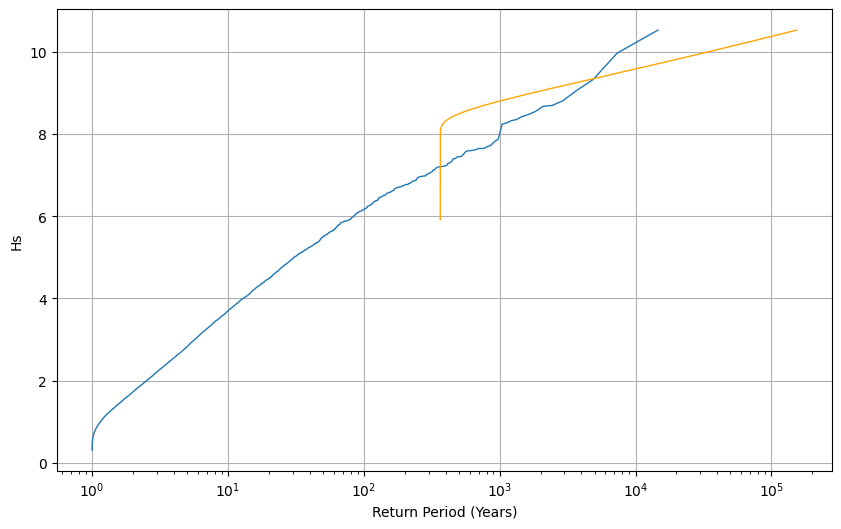

In [38]:
fig = plt.figure(figsize=(10,6))
ax= fig.add_subplot()
#T_pt, np.sort(hspt)
ax.semilogx(T_pt, np.sort(hspt), linewidth=1,markersize=1.5)
ax.semilogx(return_perd_values_gev, np.sort(x_values_gev), color = 'orange',linewidth=1,markersize=1.5)
#ax.set_xscale('log')
ax.set_xlabel('Return Period (Years)')
ax.set_ylabel('Hs')
ax.grid()
plt.show()

## Obtaining xlim value

In [39]:
from scipy.optimize import differential_evolution
ecdf_pt
def obj_fun(x):
    pt_t = 1/(1-ecdf_pt(x))
    ev_t = n_return_period/(1-stats.genextreme.cdf(x, shape_gev, loc=loc_gev, scale=scale_gev))
    return (pt_t-ev_t)**2

bounds = [(0.01, 10)]  

result = differential_evolution(obj_fun, bounds)
xlim = result.x
print("Global Min:", xlim, "Function Value:", result.fun)

Global Min: [8.86408776] Function Value: 8.271806125530277e-25


In [40]:
np.linspace(0,10,10000)[np.argmin(obj_fun(np.linspace(0,9,10000)))]

9.84898489848985

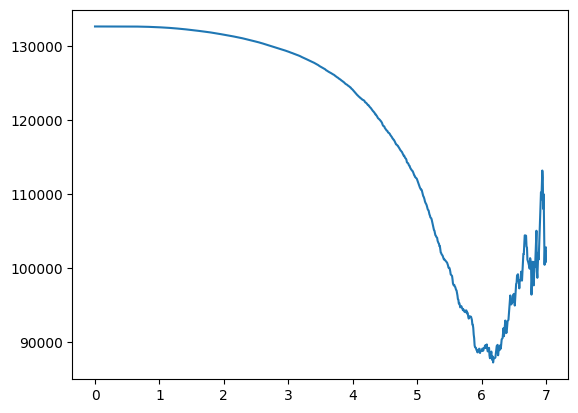

In [41]:
plt.figure()
plt.plot(np.linspace(0,7,1000), obj_fun(np.linspace(0,7,1000)))
plt.show()

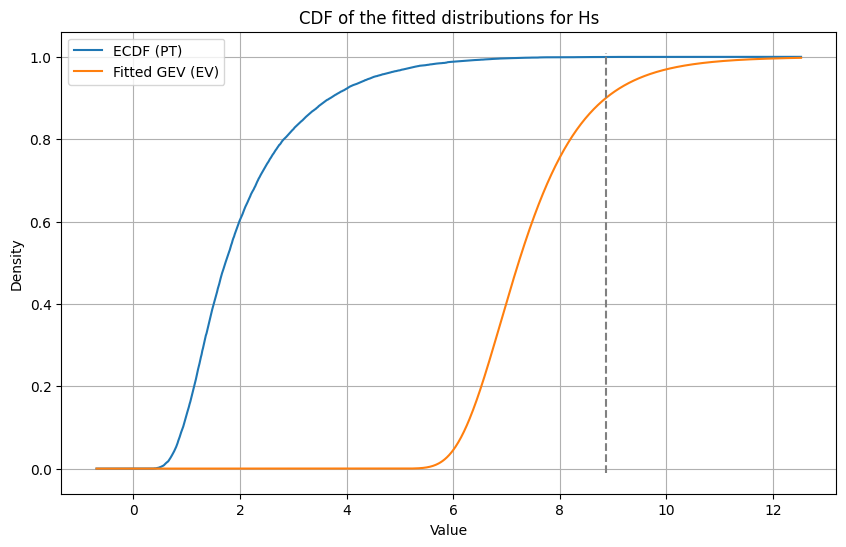

In [42]:
# Combining both pdf
# Generate x values for density plot
x_values_gev = np.linspace(min(hspt)-1, max(hspt)+2, 1000)
pdf_values_gev = stats.genextreme.pdf(x_values, shape_gev, loc=loc_gev, scale=scale_gev)
x_values = np.linspace(min(hspt)-1, max(hspt)+2, 1000)
pdf_values = stats.lognorm.pdf(x_values, shape, loc=loc, scale=scale)

# Create the plot
plt.figure(figsize=(10,6))

#plt.plot(x_values, stats.lognorm.cdf(x_values, shape, loc=loc, scale=scale), label='Fitted Lognormal (PT)')
plt.plot(x_values, ecdf_pt(x_values), label='ECDF (PT)')
plt.plot(x_values_gev, stats.genextreme.cdf(x_values_gev, shape_gev, loc=loc_gev, scale=scale_gev), label='Fitted GEV (EV)')
plt.vlines(xlim, -0.01, 1.01, linestyles='dashed', color='gray')

# Labels and title
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("CDF of the fitted distributions for Hs")
plt.legend()
plt.grid()
# Show the plot
plt.show()

In [43]:
plim_pt = ecdf_pt(xlim)
plim_ev = stats.genextreme.cdf(xlim, shape_gev, loc=loc_gev, scale=scale_gev)
print(rf"Prob lim (PT): {plim_pt}, Prob lim (EV): {plim_ev}")

Prob lim (PT): [0.99972621], Prob lim (EV): [0.9]


In [44]:
def inverse_ecdf_pt(p):
    x = np.argmin((ecdf_pt(hspt)-p)**2)
    return hspt[x]

In [45]:
# Re-scaled probability
def scaled_prob(u):
    u_ev = plim_ev+(u-plim_pt)/(1-plim_pt)*(1-plim_ev)
    return u_ev

def x_sim(probs):
    x = []
    for u in probs:
        if u > plim_pt:
            x.append(stats.genextreme.ppf(scaled_prob(u), shape_gev, loc=loc_gev, scale=scale_gev)[0])
        else:
            x.append(inverse_ecdf_pt(u))
    return np.asarray(x)


In [46]:
1/(1-0.99996), 1/(1-0.99996)/365.25/24, 1/(1-0.66)

(24999.999999974996, 2.851927903259753, 2.9411764705882355)

In [47]:
1/(1-plim_pt[0]), 1/(1-plim_pt[0])/n_return_period, 1/(1-plim_ev[0])

(3652.4999999997485, 9.99999999999931, 9.999999999999314)

In [48]:
probs = np.random.uniform(0,1,10000)
np.where(probs > plim_pt)

(array([  80,  282, 3506, 5097, 5333], dtype=int64),)

In [49]:

return_periods_sim = np.zeros(10000)
return_periods_max = []
for idx, u in enumerate(probs):
    if u > plim_pt:
        u_ev = plim_ev+(u-plim_pt)/(1-plim_pt)*(1-plim_ev)
        return_periods_sim[idx] = n_return_period/(1-u_ev[0])
        return_periods_max.append(idx)
    else: 
        return_periods_sim[idx] = 1/(1-u)
x_simulated = x_sim(probs)

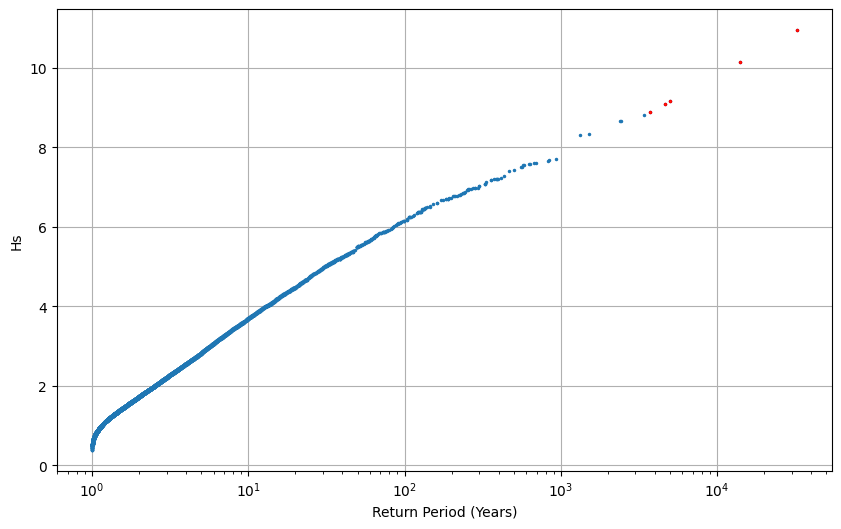

In [50]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
ax= fig.add_subplot()
ax.semilogx(return_periods_sim, x_simulated, linewidth=0, marker='o',markersize=1.5)
ax.semilogx(return_periods_sim[return_periods_max], x_simulated[return_periods_max], linewidth=0, marker='o',markersize=1.5, mec = 'r')
#ax.semilogx(T_ev, np.sort(hsmax), color = 'orange',linewidth=0, marker='o',markersize=1.5)
#ax.set_xscale('log')
ax.set_xlabel('Return Period (Years)')
ax.set_ylabel('Hs')
ax.grid()
plt.show()

## Algoritmo

#### Paso 1: Estimar los parámetros de cada distribución (ya hecho arriba)

#### Paso2: Aplicar la transformación a la seria histórica 
$$ 
\begin{align*}
\Phi(z_t) & = F^{PT}(x_t), \quad \text{if } x_t\leq x_{lim} \\
p_{lim}^{EV} + \frac{\Phi(z_t)-p_{lim}^{PT}}{1-p_{lim}^{PT}} (1- p_{lim}^{EV}) &= F^{EV}(x_t), \quad \text{if } x_t > x_{lim}
\end{align*}
$$

In [54]:
zt = np.zeros(len(hspt))
for idx, xt in enumerate(hspt):
    if xt <= xlim:
        zt[idx] = stats.norm.ppf(ecdf_pt(xt))
    else:
        zt[idx] = stats.norm.ppf((plim_pt+(stats.genextreme.cdf(xt, shape_gev, loc=loc_gev, scale=scale_gev) - plim_ev)/(1-plim_ev)*(1-plim_pt)))[0]

In [55]:
zt

array([-1.06852435, -0.48271938,  0.13093746, ..., -0.69542361,
       -0.68107383, -0.94546481])

#### Paso 3: Ajustar un ARMA a la serie transformada ($z_t$)

Obtener la media (0) y varianza de los errores del ARMA ($\sigma_{\varepsilon}^2$)

#### Paso 4: Simular errores independientes ($\varepsilon^{sim}_t$) y normales con media cero y varianza $\sigma_{\varepsilon}^2$

#### Paso 5: Introducir en el ARMA ajustado los errores generados ($\varepsilon_{t}^{sim}$)

#### Paso 6: Calcular la serie simulada ($u_t^{sim}=\Phi(z_t^{sim})$)

#### Paso 7: Invertir la transformación con la formula (6)

## Clase

In [542]:
from Daily_Hs_StormSurge_ScipyJax.non_stationary_model import NonStationaryModel
import jax.numpy as jnp
import time


xt = hsmax
t = times
covariates_loc = np.column_stack([scaled_covariates[key] for key in scaled_covariates.keys()])
# Supongamos que covariates_sc y covariates_sh son iguales a covariates_loc para este ejemplo
covariates_sc = covariates_loc.copy()
covariates_sh = covariates_loc.copy()

covariates_loc=jnp.array(covariates_loc)
covariates_sc=jnp.array(covariates_sc)
covariates_sh=jnp.array(covariates_sh)

# 1. Definición de los datos
xt=jnp.array(xt)
t =jnp.array(t)
covariates_loc=jnp.array(covariates_loc)
covariates_sc=jnp.array(covariates_sc)
covariates_sh=jnp.array(covariates_sh)

# Parámetros iniciales
n_harmonics_loc = 0     # Número de armónicos para ubicación
n_harmonics_scale = 0   # Número de armónicos para escala
n_harmonics_shape = 0   # Número de armónicos para forma
betaT = 0   # Tendencia en localización
betaT2 = 0  # Tendencia en escala
# rhocoeff = 6000  # Coeficiente de penalización Lasso

model_lasso = NonStationaryModel(
    xt=xt,
    t=t,
    covariates_loc=jnp.empty((len(xt),0)),
    covariates_sc=jnp.empty((len(xt),0)),
    covariates_sh=jnp.empty((len(xt),0)),
    n_harmonics_loc=n_harmonics_loc,
    n_harmonics_scale=n_harmonics_scale,
    n_harmonics_shape=n_harmonics_shape,
    betaT=betaT,
    betaT2=betaT2,
    #rhocoeff=rhocoeff,
    regularization_type="lasso",
    example='Monthly Hs'
)

In [540]:
print("Ajustando modelo con regularización Lasso...")
# Iniciar el temporizador
start_time = time.time()
result_lasso = model_lasso.fit(rhocoeff=0, method='lbfgsb', maxiter=1000, linesearch='zoom')  # linesearch='hager-zhang'
# Detener el temporizador
end_time = time.time()
# Calcular el tiempo transcurrido
elapsed_time = end_time - start_time
print(f"Tiempo de ejecución L-BFGS-B Grid Search con lasso: {elapsed_time:.2f} segundos")
print("Ajuste completado.\n")

# 9. Obtener y mostrar parámetros ajustados para Lasso
print(f"Valor óptimo de verosimilitud: {result_lasso['loglik']}")
print("\nParámetros ajustados con Lasso:")
model_lasso.summary()

final_parameters = result_lasso['params']

Ajustando modelo con regularización Lasso...
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 2744.695068359375 Stepsize:1.0  Decrease Error:2744.695068359375  Curvature Error:1873.285400390625 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 4045.01123046875 Stepsize:0.5  Decrease Error:4045.01123046875  Curvature Error:3306.00537109375 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): 5563.8720703125 Stepsize:0.25  Decrease Error:511.46734619140625  Curvature Error:5563.8720703125 
INFO: jaxopt.ZoomLineSearch: Iter: 4 Minimum Decrease & Curvature Errors (stop. crit.): 270.4439392089844 Stepsize:0.125  Decrease Error:6.7424492835998535  Curvature Error:270.4439392089844 
INFO: jaxopt.ZoomLineSearch: Iter: 5 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.0762811228632927  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Mi

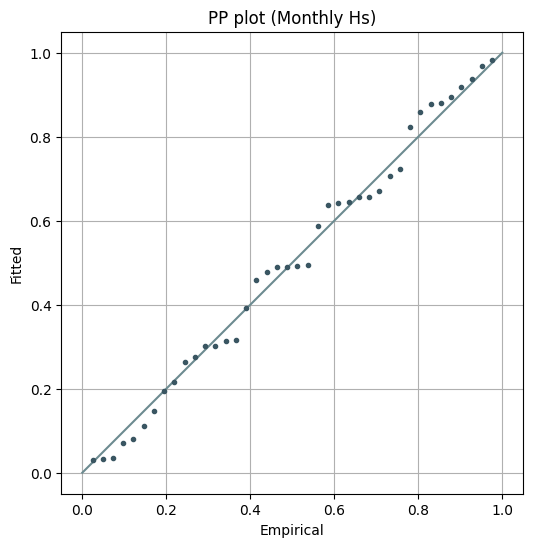

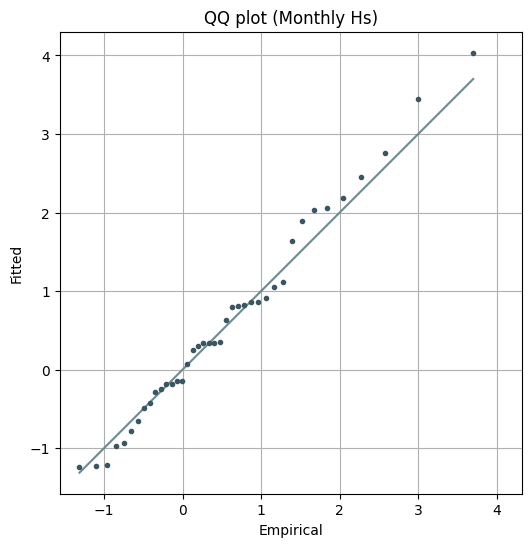

In [541]:
model_lasso.PPplot()
model_lasso.QQplot()

## Obtaining xlim value

In [ ]:
from scipy.optimize import minimize

minimize(lambda x: 1/(1-))